# imports and loading the dataset

In [330]:
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
import seaborn as sns

In [331]:
df = pd.read_csv('kagglex-cohort4/train.csv')

# very basic EDA to check data imbalance and null values

In [332]:
df.head()

id    brand          model  model_year  milage fuel_type  \
0   0     Ford   F-150 Lariat        2018   74349  Gasoline   
1   1      BMW          335 i        2007   80000  Gasoline   
2   2   Jaguar      XF Luxury        2009   91491  Gasoline   
3   3      BMW   X7 xDrive40i        2022    2437    Hybrid   
4   4  Pontiac  Firebird Base        2001  111000  Gasoline   

                                              engine  \
0      375.0HP 3.5L V6 Cylinder Engine Gasoline Fuel   
1  300.0HP 3.0L Straight 6 Cylinder Engine Gasoli...   
2       300.0HP 4.2L 8 Cylinder Engine Gasoline Fuel   
3  335.0HP 3.0L Straight 6 Cylinder Engine Gasoli...   
4      200.0HP 3.8L V6 Cylinder Engine Gasoline Fuel   

                     transmission ext_col int_col       accident clean_title  \
0                    10-Speed A/T    Blue    Gray  None reported         Yes   
1                     6-Speed M/T   Black   Black  None reported         Yes   
2                     6-Speed A/T  Purple   Beige  None reported         Yes   
3  Transmission w/Dual Shift Mode    Gray   Brown  None reported         Yes   
4                             A/T   White   Black  None reported         Yes   

   price  
0  11000  
1   8250  
2  15000  
3  63500  
4   7850

In [333]:
df.describe()

id    model_year         milage         price
count  54273.000000  54273.000000   54273.000000  5.427300e+04
mean   27136.000000   2015.091979   72746.175667  3.921844e+04
std    15667.409917      5.588909   50469.490448  7.282634e+04
min        0.000000   1974.000000     100.000000  2.000000e+03
25%    13568.000000   2012.000000   32268.000000  1.550000e+04
50%    27136.000000   2016.000000   66107.000000  2.800000e+04
75%    40704.000000   2019.000000  102000.000000  4.500000e+04
max    54272.000000   2024.000000  405000.000000  2.954083e+06

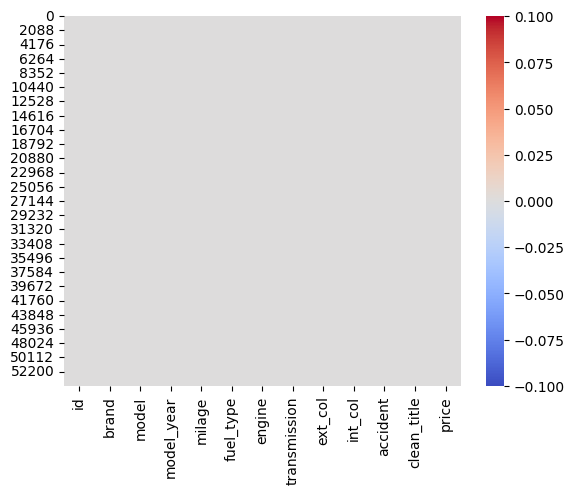

In [334]:
sns.heatmap(df.isnull(),cmap="coolwarm")
plt.show()

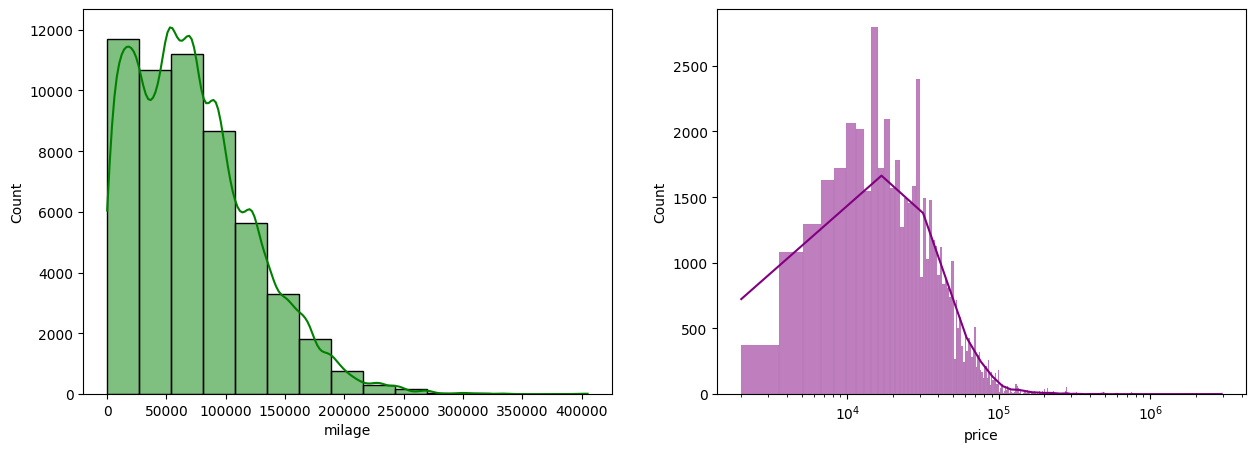

In [335]:
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)

sns.histplot(df['milage'],color="green",bins=15,kde=True)

plt.subplot(1, 2, 2)

sns.histplot(df['price'],color="purple",kde=True)
plt.xscale('log')


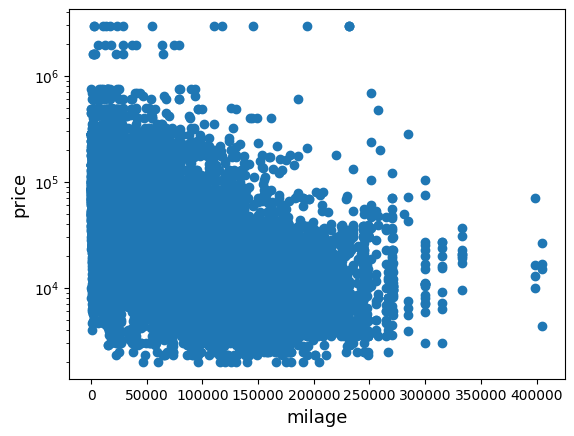

In [336]:
fig, ax = plt.subplots()
ax.scatter(x = df['milage'], y = df['price'])
plt.ylabel('price', fontsize=13)
plt.yscale('log')
plt.xlabel('milage', fontsize=13)
plt.show()

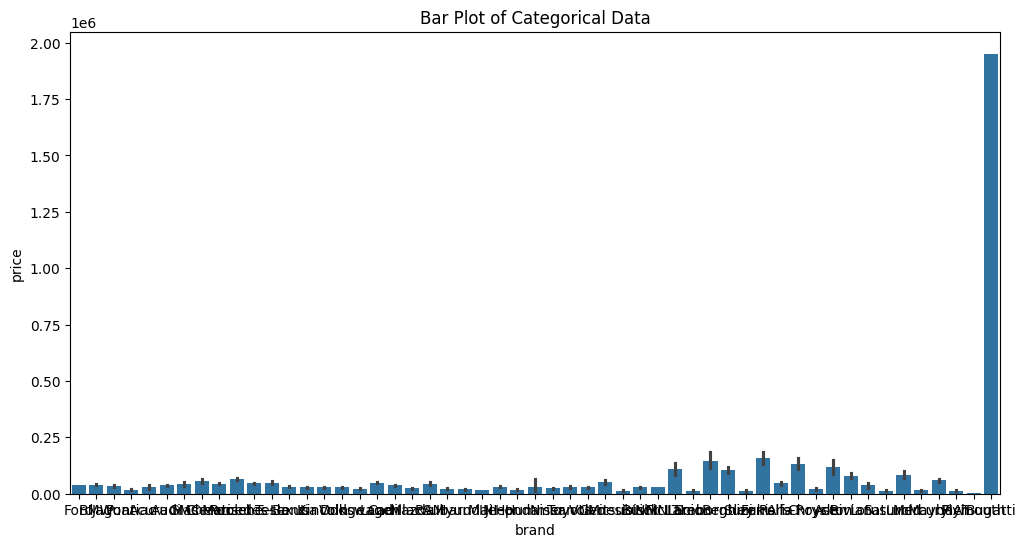

In [337]:
plt.figure(figsize=(12, 6))
sns.barplot(x='brand', y='price', data=df)
plt.title('Bar Plot of Categorical Data')
plt.show()

In [338]:
for column in df.iloc[:,1:-1].columns:
    print(f'column name: {column} \t column unique values count:\n {df[column].value_counts()}')

column name: brand 	 column unique values count:
 brand
BMW              7369
Ford             6706
Mercedes-Benz    5087
Chevrolet        4424
Audi             2922
Porsche          2627
Toyota           2315
Lexus            2257
Jeep             2247
Land             1995
Cadillac         1565
Nissan           1252
GMC              1076
Dodge            1011
RAM               966
INFINITI          957
Lincoln           767
Mazda             748
Subaru            739
Hyundai           694
Jaguar            661
Volkswagen        628
Honda             624
Acura             580
Kia               526
Volvo             452
MINI              364
Maserati          293
Bentley           284
Chrysler          258
Genesis           249
Buick             228
Mitsubishi        182
Hummer            176
Pontiac           149
Alfa              144
Rolls-Royce       142
Lamborghini       122
Tesla             110
Ferrari            87
Saturn             58
Scion              53
Aston              5

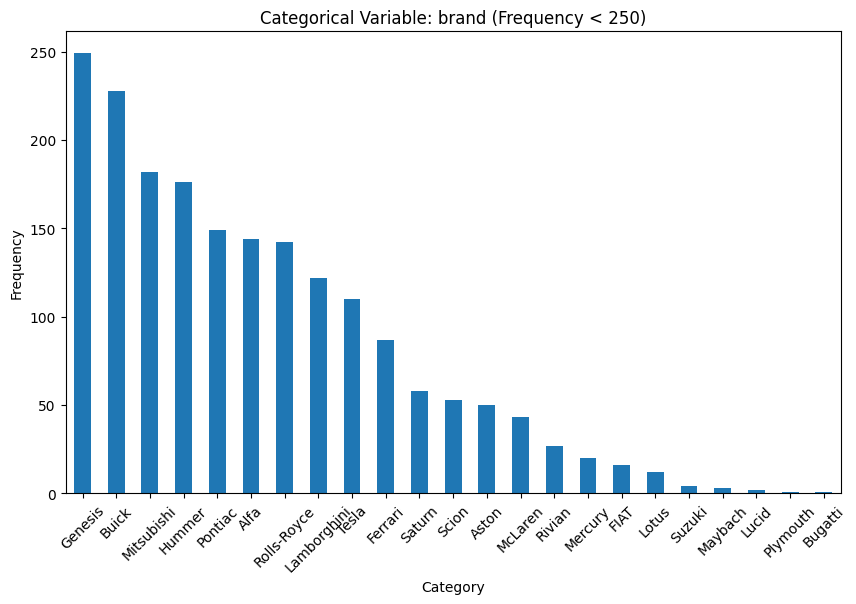

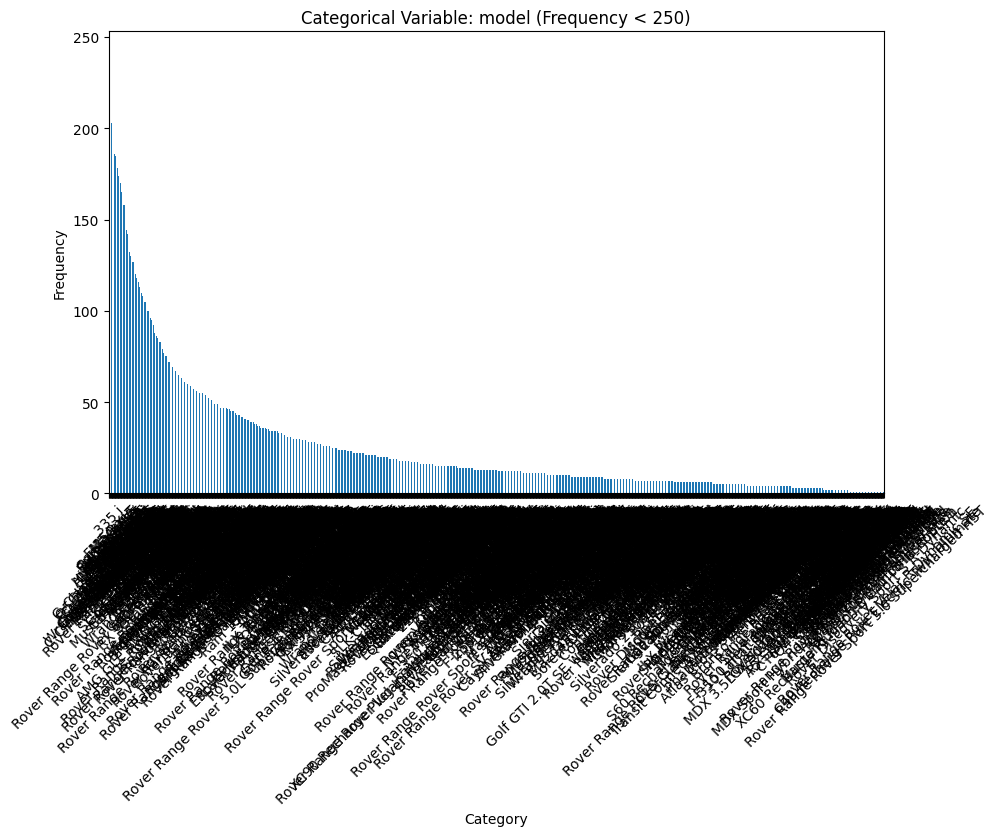

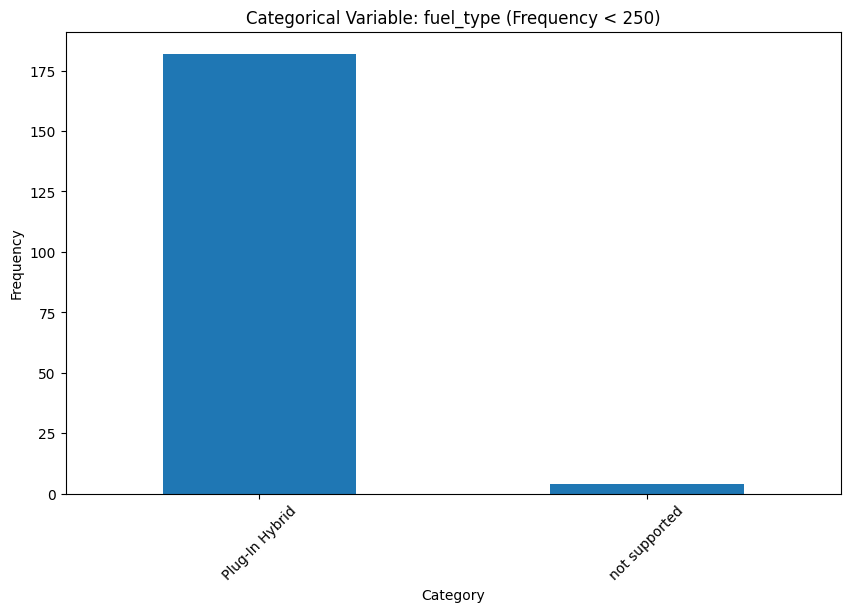

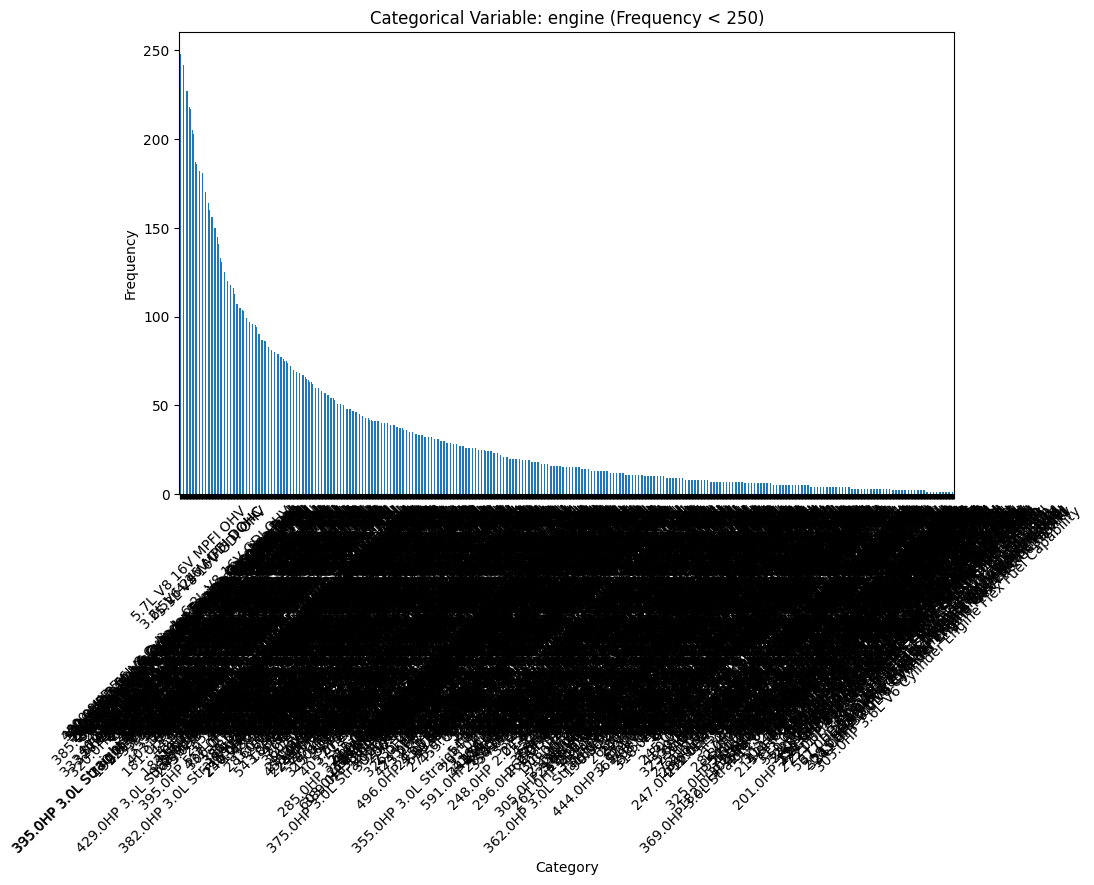

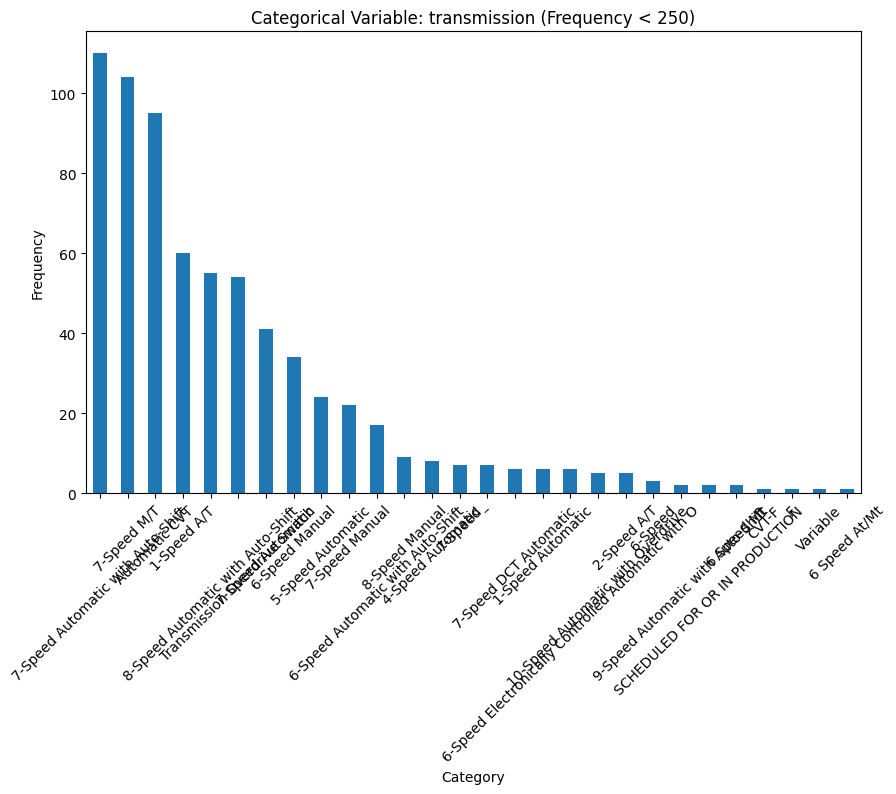

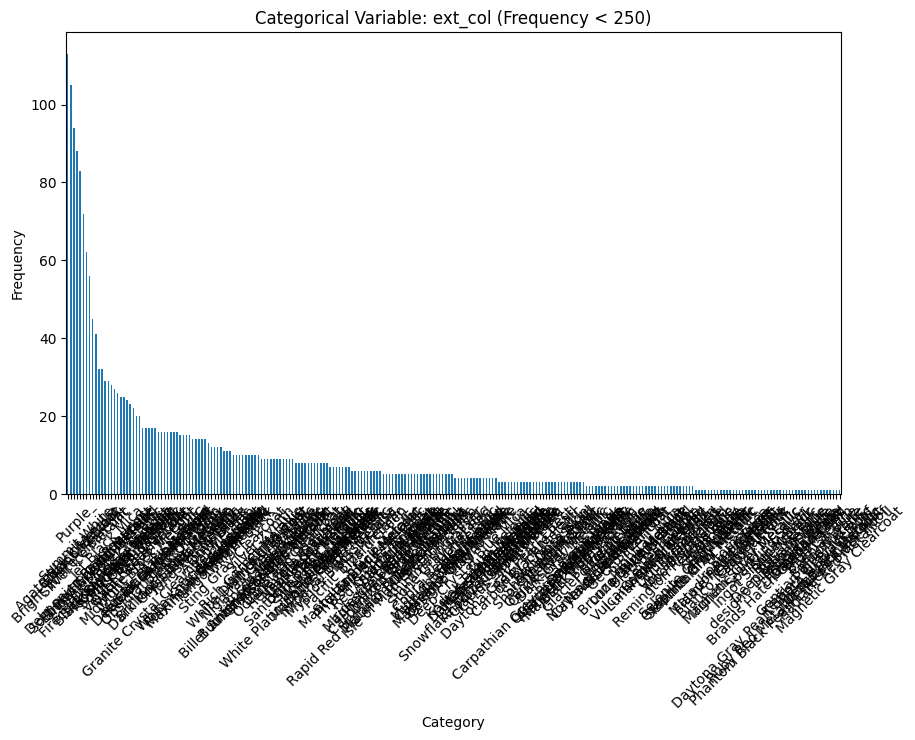

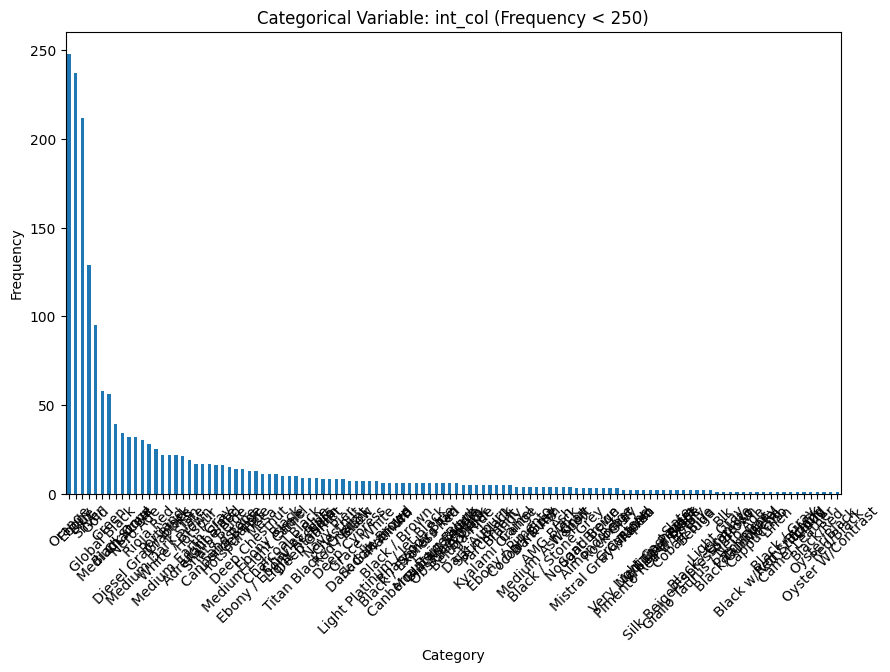

In [339]:
import matplotlib.pyplot as plt
import seaborn as sns

threshold_frequency = 250

categorical_columns = df.select_dtypes(include=['object', 'category']).columns

for col in categorical_columns:
    value_counts_col = df[col].value_counts()
    
    less_than_threshold = value_counts_col[value_counts_col < threshold_frequency]
    
    if not less_than_threshold.empty:
        plt.figure(figsize=(10, 6))
        less_than_threshold.plot(kind='bar')
        plt.title(f'Categorical Variable: {col} (Frequency < {threshold_frequency})')
        plt.xlabel('Category')
        plt.ylabel('Frequency')
        plt.xticks(rotation=45)
        plt.show()


# Preprocessing the data 

In [340]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures


In [341]:
df = pd.read_csv('kagglex-cohort4/train.csv')

threshold = 3

z_scores = df.select_dtypes(include=['number']).apply(lambda x: np.abs((x - x.mean()) / x.std()))

df = df[(z_scores < threshold).all(axis=1)]

encoded_columns = ['int_col', 'ext_col']
ordinal_encoder = OrdinalEncoder()
df[encoded_columns] = ordinal_encoder.fit_transform(df[encoded_columns])

# encoded_column = ['fuel_type']
# one_hot_encoder = OneHotEncoder()
# encoded_features = one_hot_encoder.fit_transform(df[encoded_column])

# new_column_names = one_hot_encoder.get_feature_names_out(encoded_column)

# df.drop(columns=encoded_column, inplace=True)
# df[new_column_names] = encoded_features.toarray()


In [342]:
# df['model_year>2010']=df['model_year'].astype(int).apply(lambda age:age >2010)
combination_test=[]
columns_to_ignore=['id','price','clean_title','model_year']
for column in df.columns:
    if column not in columns_to_ignore:
        for column2 in df.columns:
            if column2 not in columns_to_ignore:
                if column!=column2:
                    temp_df = df.copy()
                    bin_edges = range(1970, 2031, 5)
                    bin_labels = [f'{start}-{start+9}' for start in bin_edges[:-1]]
                    temp_df['model_year_bins'] = pd.cut(temp_df['model_year'], bins=bin_edges, labels=bin_labels, right=False)
                    temp_df[column] = temp_df[column].astype(str) + '-' + temp_df[column2].astype(str)
                    temp_df.rename(columns={column:column+'-'+column2},inplace=True)
                    temp_df.drop(column2,inplace=True,axis=1)
                    combination_test.append(temp_df)
                    
# df['ext_col'] = df['ext_col']+'-'+df['int_col']
# df.rename(columns={'ext_col': 'combined_col'}, inplace=True)
bin_edges = range(1970, 2031, 5)
bin_labels = [f'{start}-{start+9}' for start in bin_edges[:-1]]
df['model_year_bins'] = pd.cut(df['model_year'], bins=bin_edges, labels=bin_labels, right=False)

In [343]:
df.drop('model_year',axis=1,inplace=True)
df.drop('clean_title',axis=1,inplace=True)
# df.drop('int_col',axis=1,inplace=True)

In [344]:
categorical_columns = df.select_dtypes(include=['object', 'category']).columns
threshold_frequency = 250

for col in categorical_columns:
    value_counts_col = df[col].value_counts()
    
    less_than_threshold = value_counts_col[value_counts_col < threshold_frequency]
    
    df[col] = df[col].apply(lambda x: 'Other' if x in less_than_threshold else x)

#ext_col + fuel_type gave lowest rmse
for df in combination_test:
    categorical_columns = df.select_dtypes(include=['object', 'category']).columns
    threshold_frequency = 250

    for col in categorical_columns:
        value_counts_col = df[col].value_counts()
        
        less_than_threshold = value_counts_col[value_counts_col < threshold_frequency]
        
        df[col] = df[col].apply(lambda x: 'Other' if x in less_than_threshold else x)
    for col in categorical_columns:
        category_frequency = df[col].value_counts(normalize=True)
        df[col] = df[col].map(category_frequency)


In [345]:
for col in categorical_columns:
    category_frequency = df[col].value_counts(normalize=True)
    df[col] = df[col].map(category_frequency)

# training

RMSE for DF 1: 23548.766986291084


c:\Users\avira\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


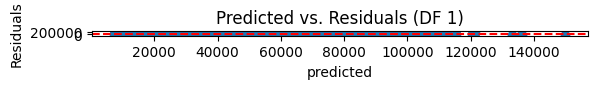

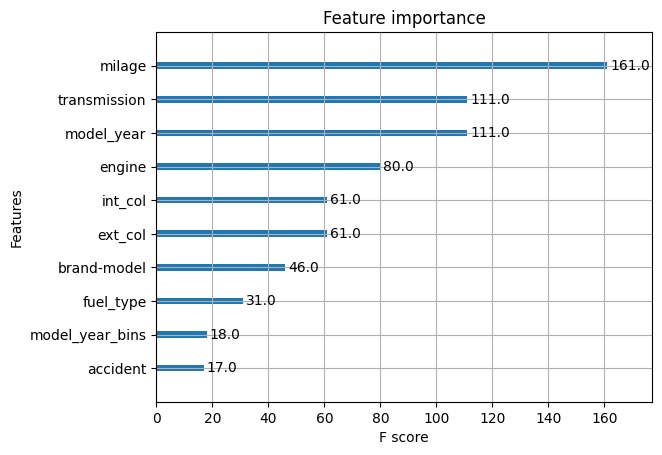

RMSE for DF 2: 24550.398014374816


c:\Users\avira\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


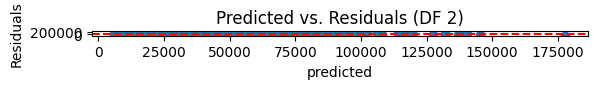

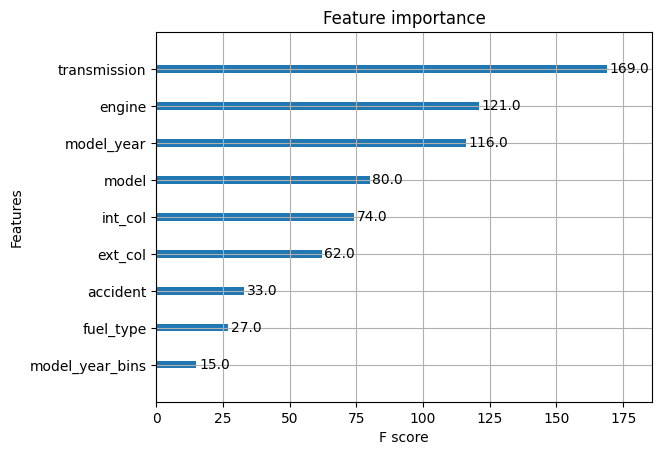

RMSE for DF 3: 23204.382090223295


c:\Users\avira\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


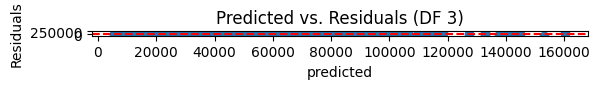

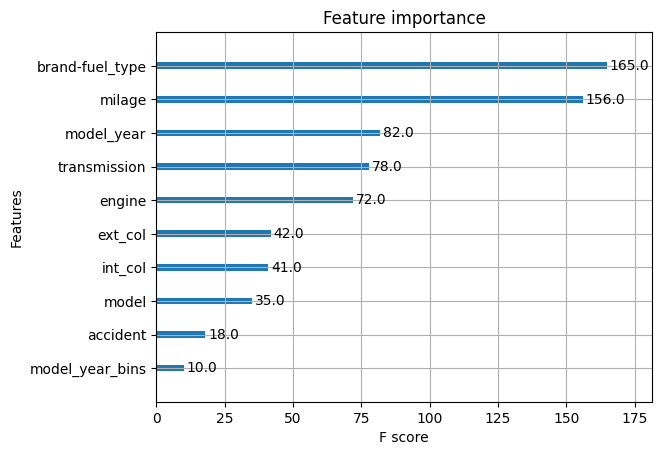

RMSE for DF 4: 23579.013026662185


c:\Users\avira\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


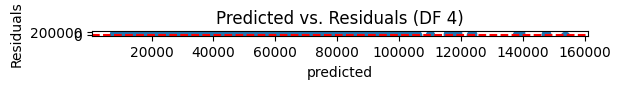

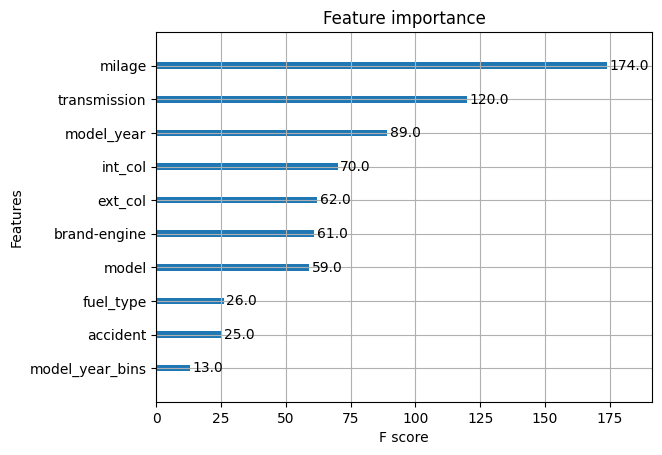

RMSE for DF 5: 23582.154754556694


c:\Users\avira\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


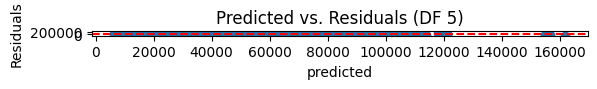

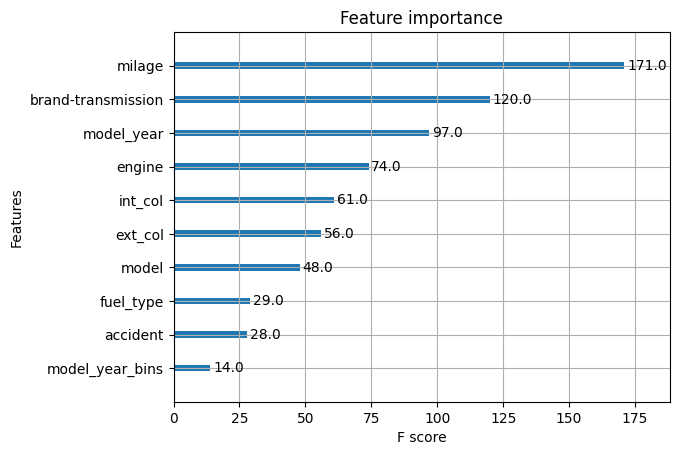

RMSE for DF 6: 23488.55468751623


c:\Users\avira\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


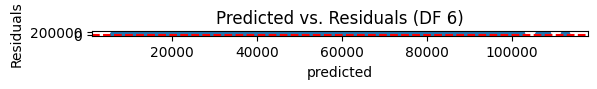

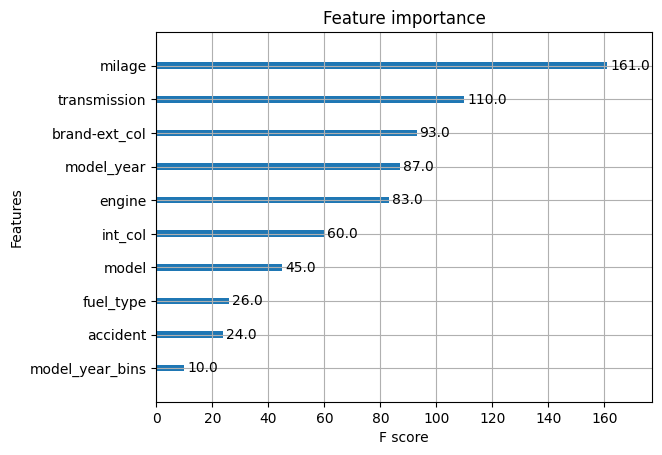

RMSE for DF 7: 23404.969064053745


c:\Users\avira\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


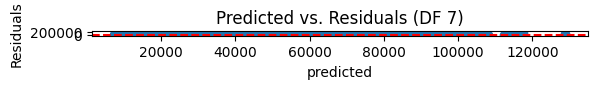

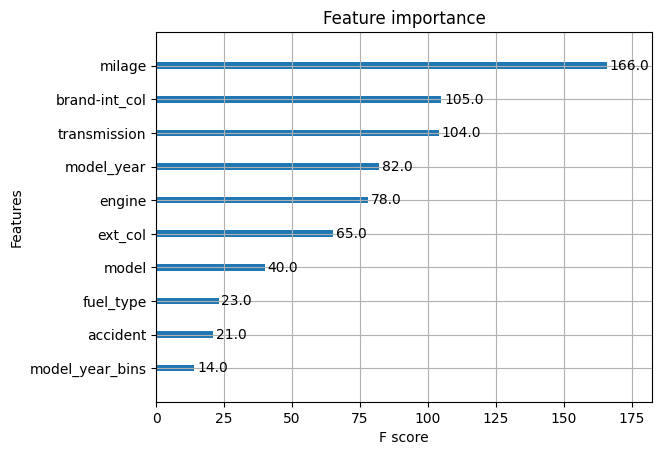

RMSE for DF 8: 23298.453944698922


c:\Users\avira\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


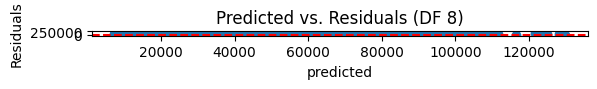

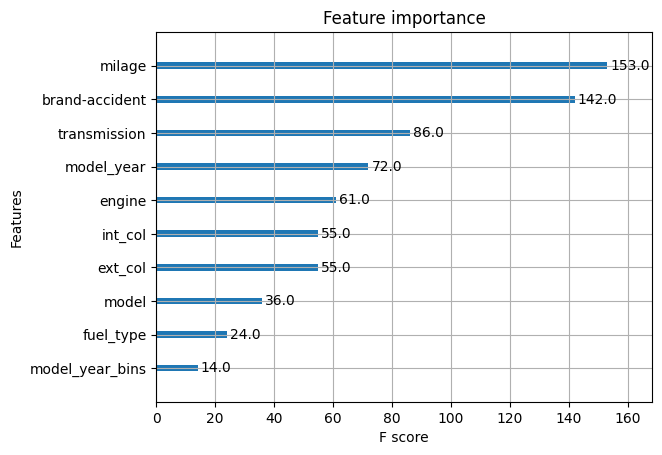

RMSE for DF 9: 23548.766986291084


c:\Users\avira\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


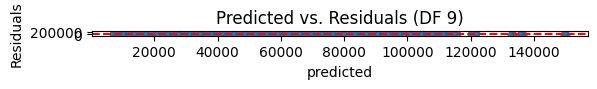

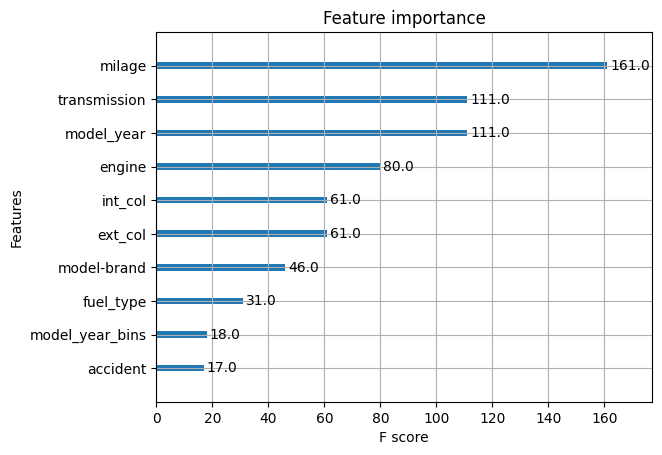

RMSE for DF 10: 24069.690638663204


c:\Users\avira\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


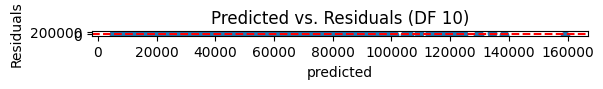

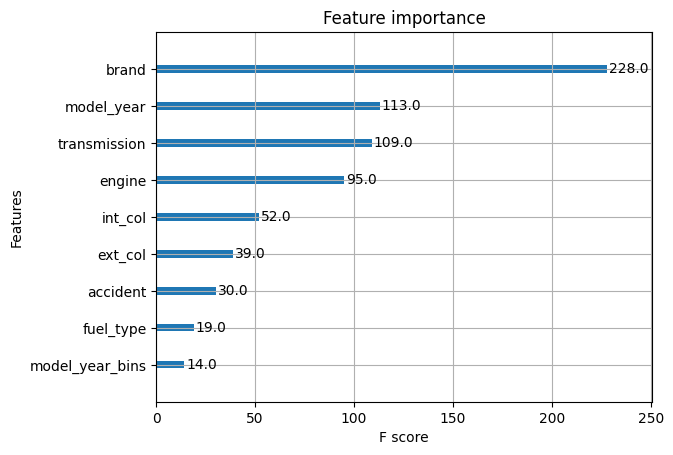

RMSE for DF 11: 23164.143208640497


c:\Users\avira\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


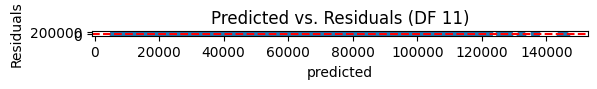

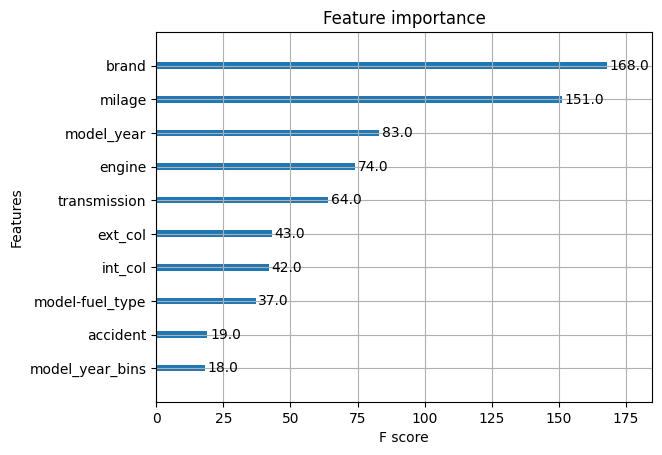

RMSE for DF 12: 23291.610550941485


c:\Users\avira\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


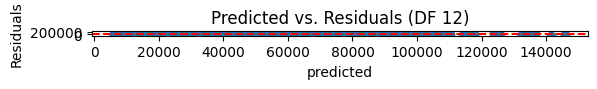

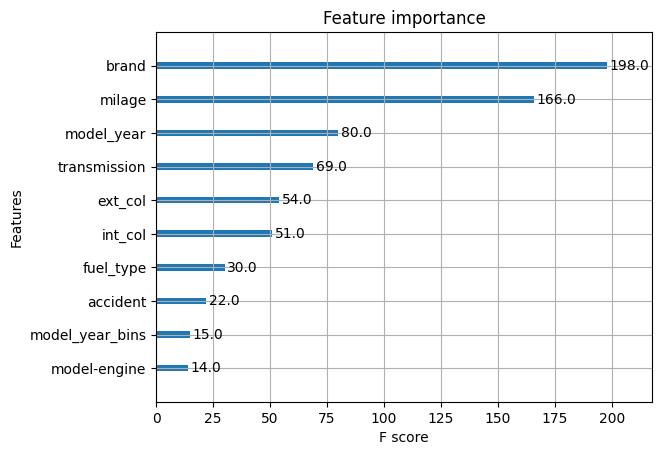

c:\Users\avira\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


RMSE for DF 13: 23226.98492041968


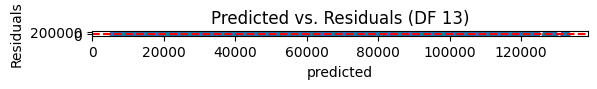

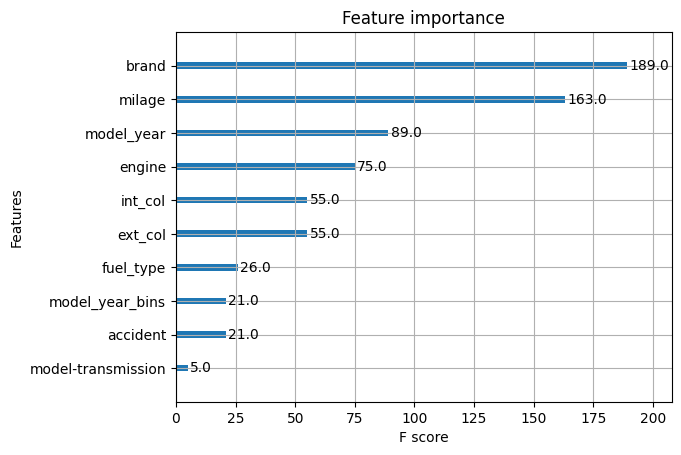

RMSE for DF 14: 23184.924734575005


c:\Users\avira\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


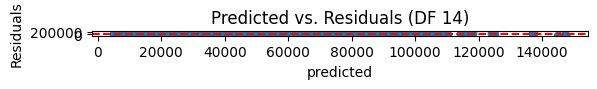

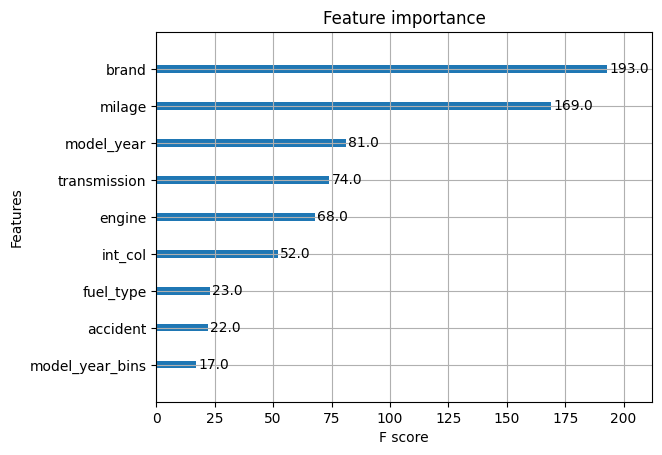

RMSE for DF 15: 23181.65487080581


c:\Users\avira\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


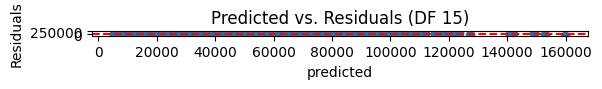

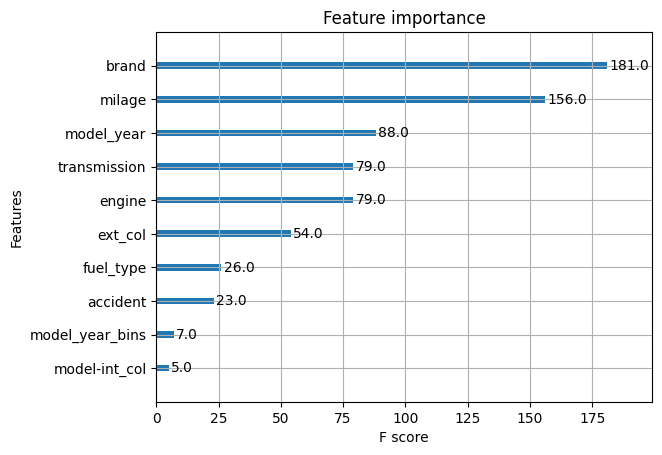

RMSE for DF 16: 23209.988185000864


c:\Users\avira\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


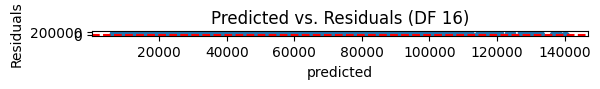

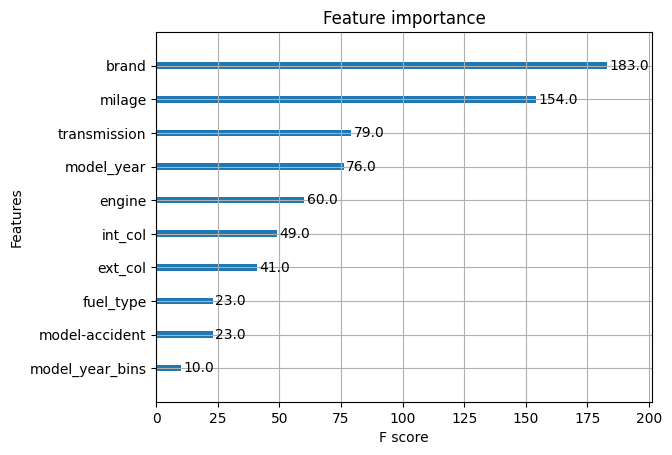

RMSE for DF 17: 24540.72242536849


c:\Users\avira\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


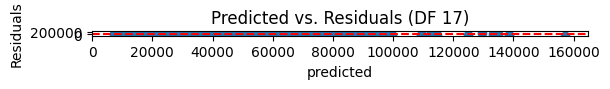

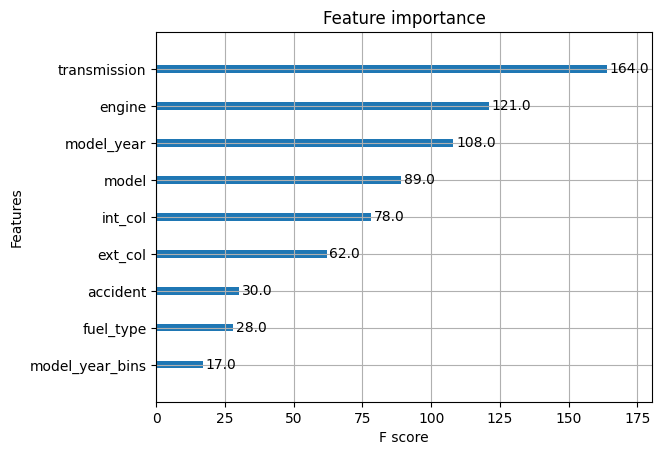

RMSE for DF 18: 24072.8125277104


c:\Users\avira\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


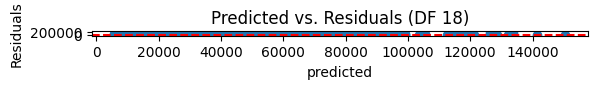

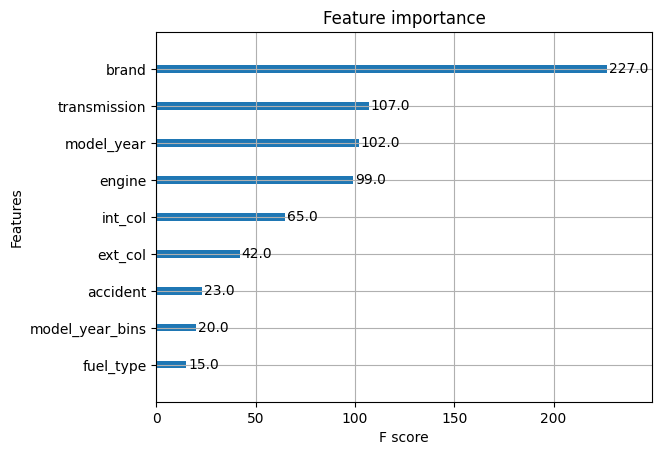

RMSE for DF 19: 24013.795293008494


c:\Users\avira\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


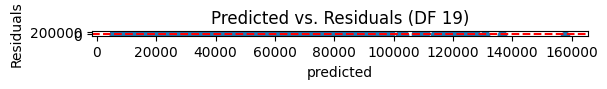

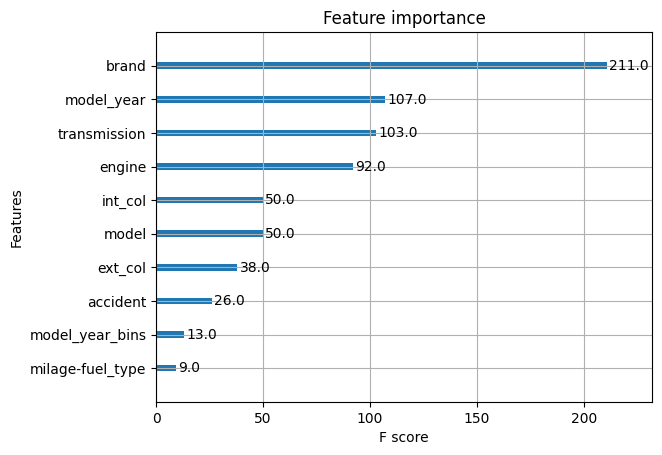

RMSE for DF 20: 24170.855240061075


c:\Users\avira\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


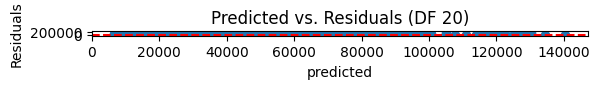

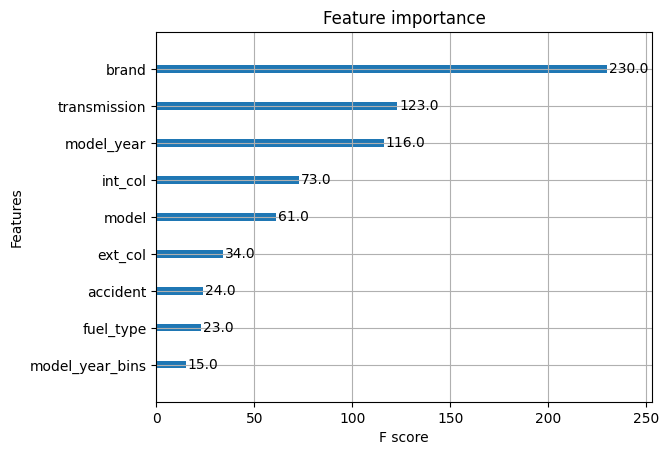

RMSE for DF 21: 24131.704849428217


c:\Users\avira\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


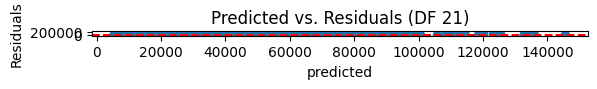

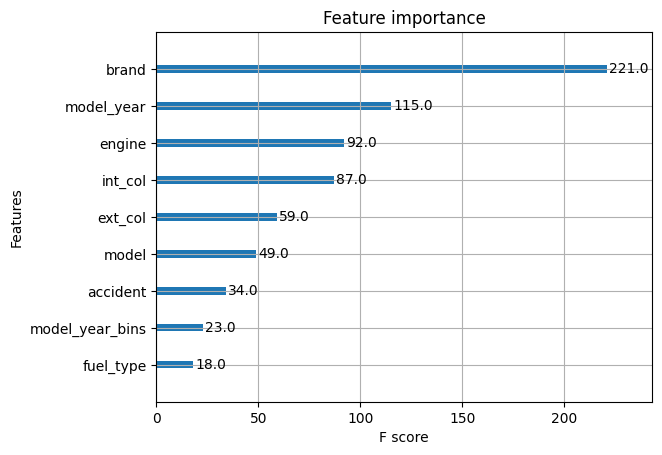

RMSE for DF 22: 23995.223112051845


c:\Users\avira\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


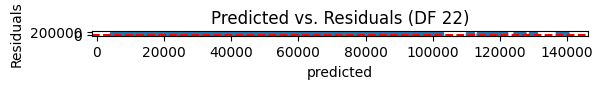

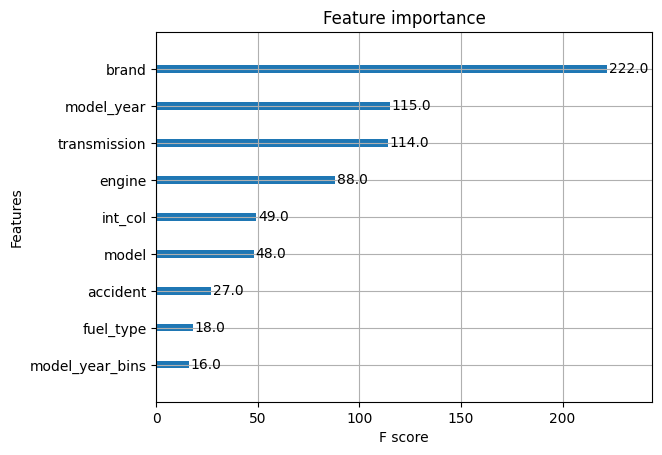

RMSE for DF 23: 24044.39557323415


c:\Users\avira\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


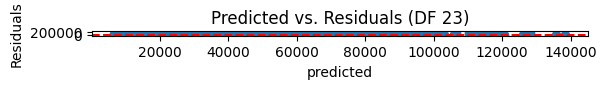

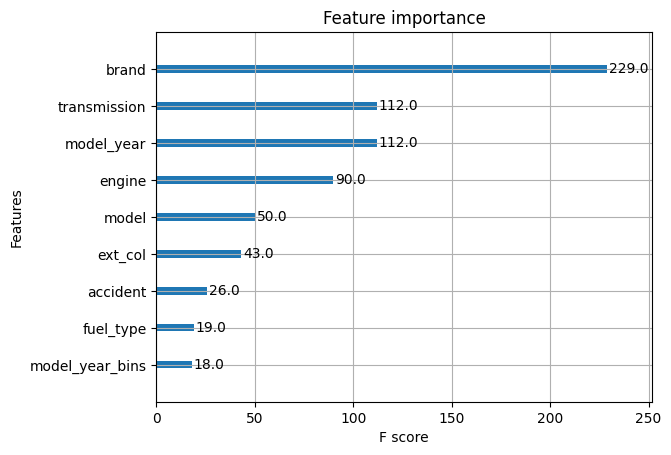

RMSE for DF 24: 24118.318959017422


c:\Users\avira\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


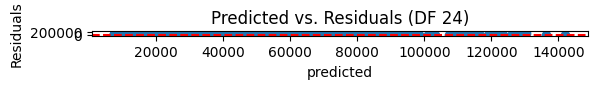

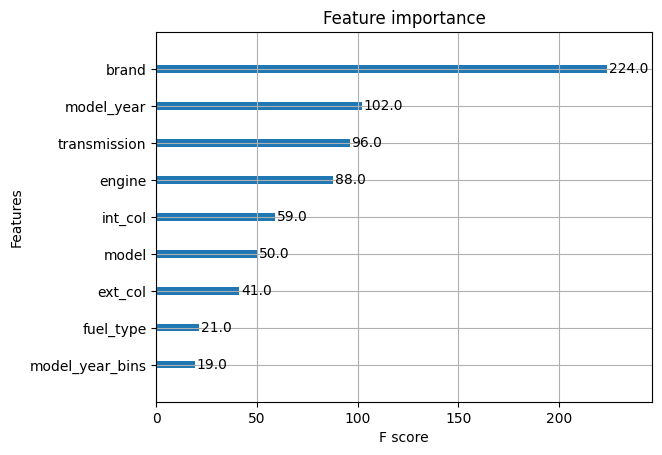

RMSE for DF 25: 23230.233914747565


c:\Users\avira\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


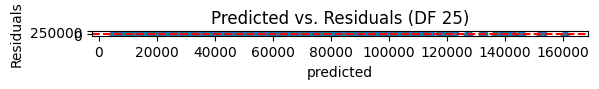

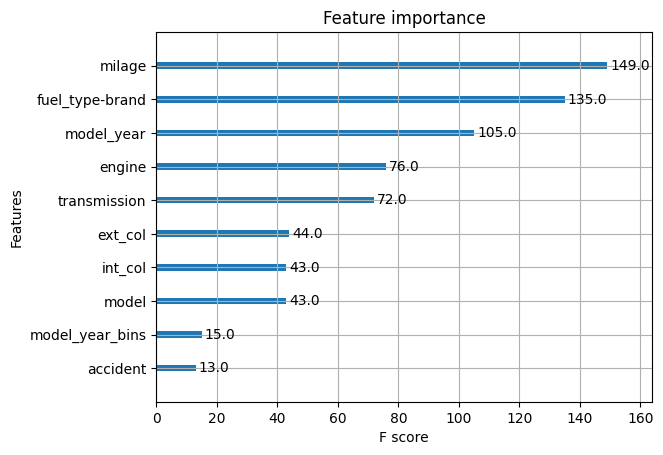

RMSE for DF 26: 23228.01891701286


c:\Users\avira\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


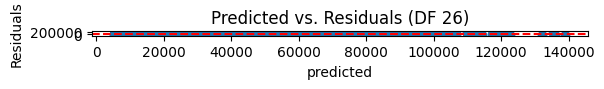

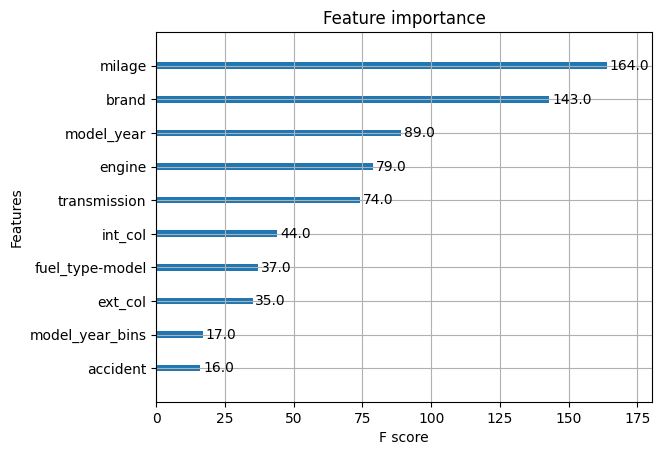

RMSE for DF 27: 24013.795293008494


c:\Users\avira\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


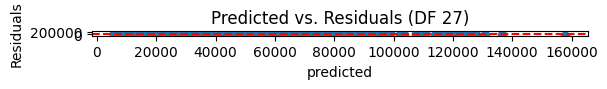

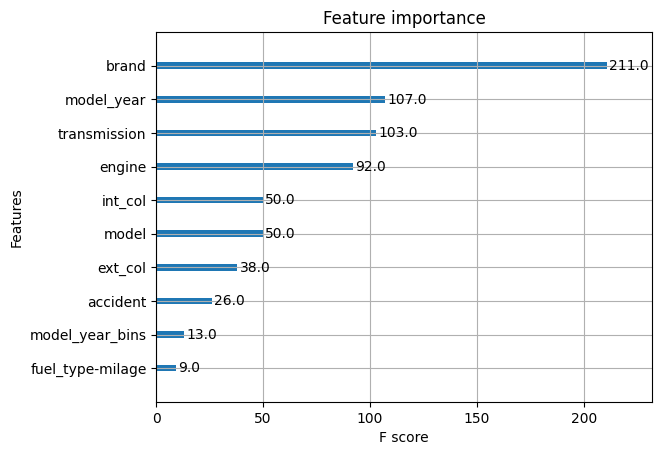

RMSE for DF 28: 23132.989694354703


c:\Users\avira\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


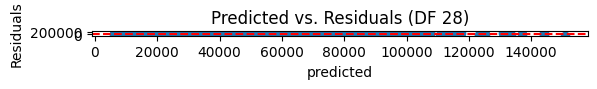

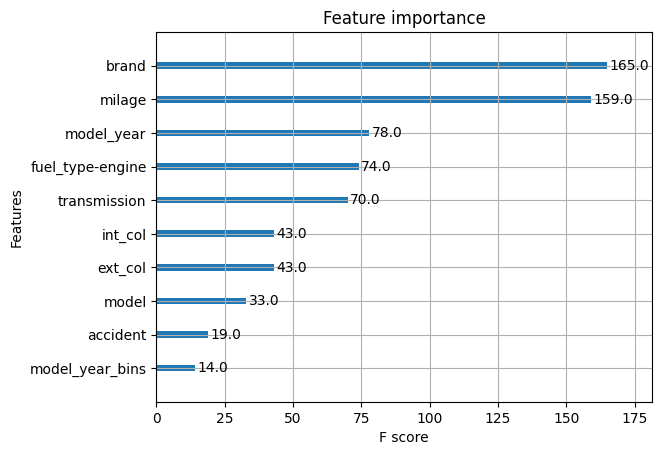

RMSE for DF 29: 23170.28444738204


c:\Users\avira\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


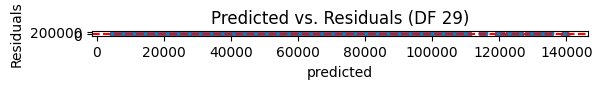

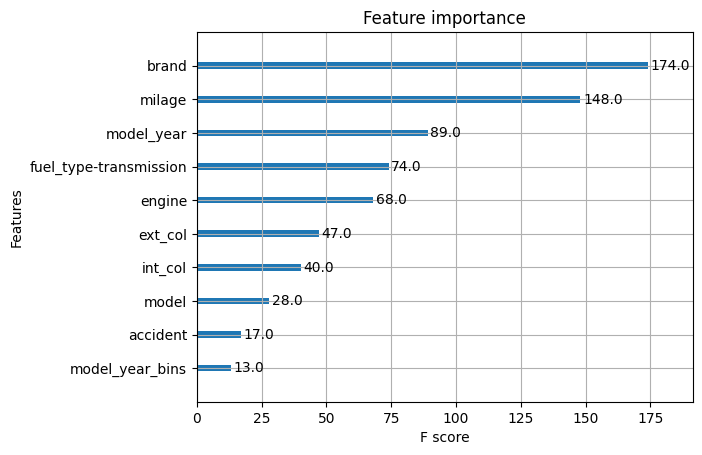

c:\Users\avira\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


RMSE for DF 30: 23146.489206435745


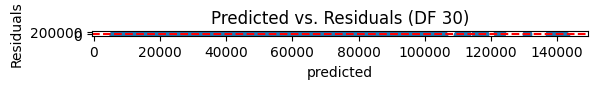

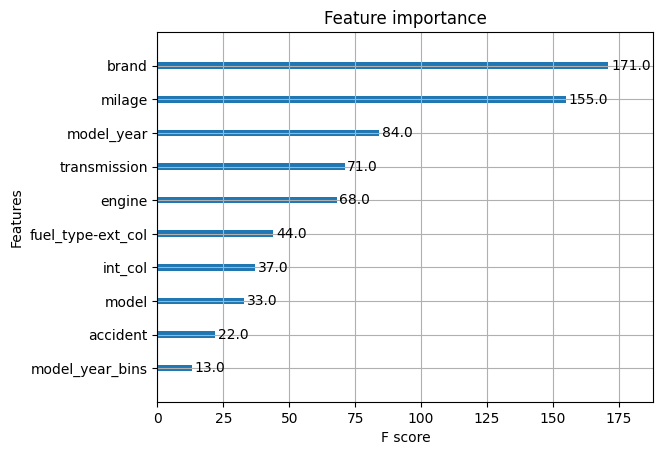

RMSE for DF 31: 23164.398439933768


c:\Users\avira\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


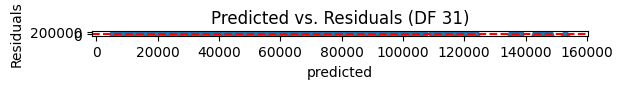

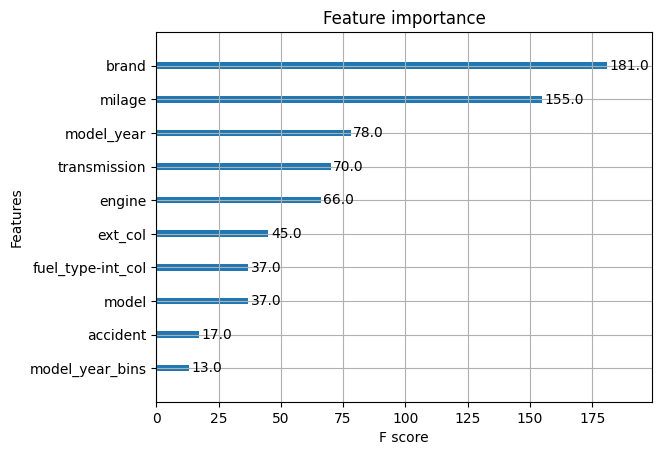

RMSE for DF 32: 23151.622547136107


c:\Users\avira\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


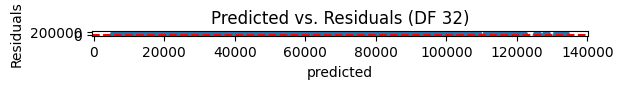

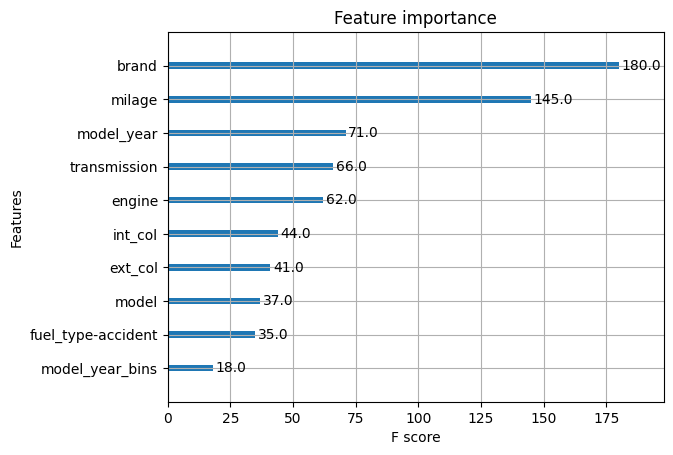

RMSE for DF 33: 23584.625120006396


c:\Users\avira\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


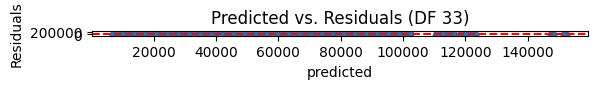

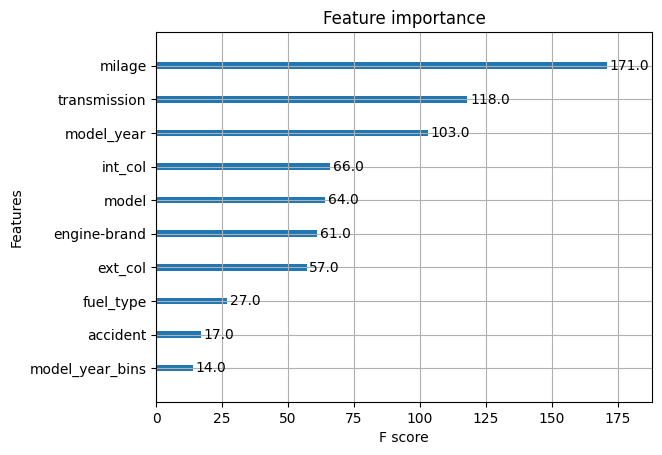

RMSE for DF 34: 23338.754874153372


c:\Users\avira\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


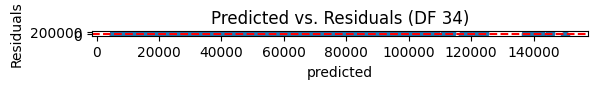

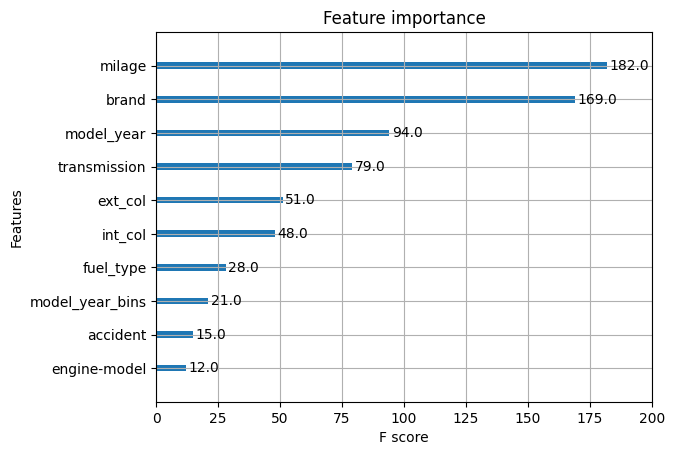

RMSE for DF 35: 24179.75748112626


c:\Users\avira\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


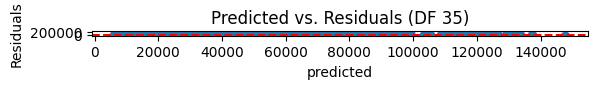

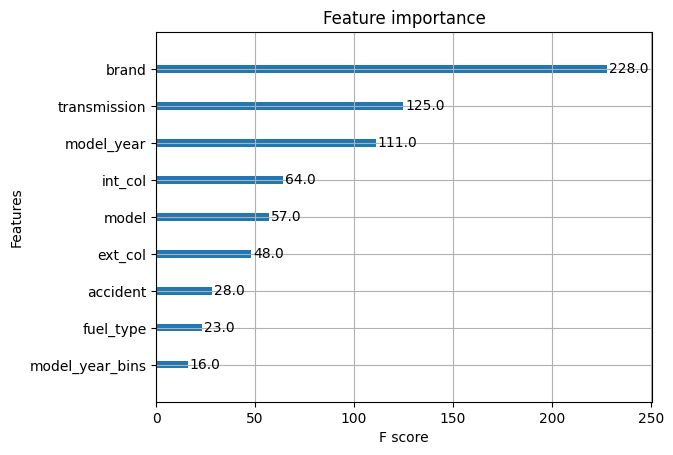

RMSE for DF 36: 23132.989694354703


c:\Users\avira\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


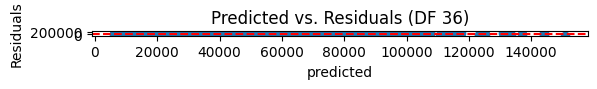

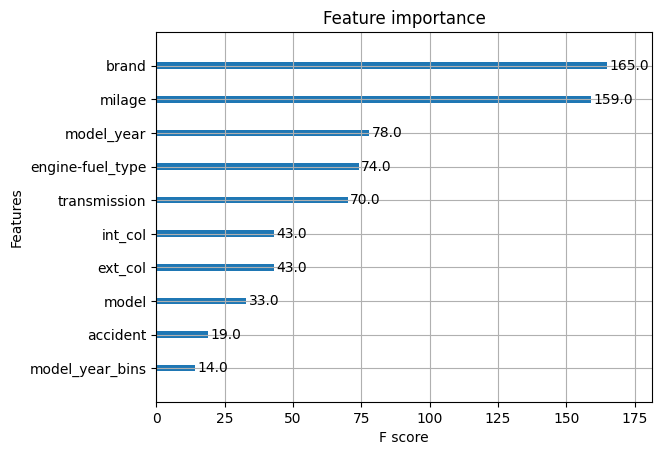

RMSE for DF 37: 23320.291658520622


c:\Users\avira\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


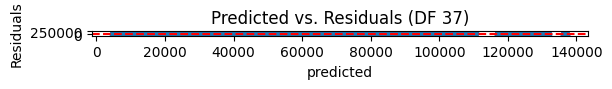

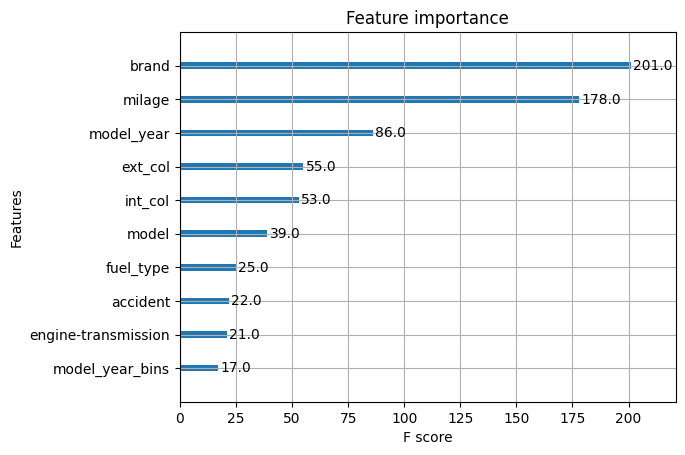

RMSE for DF 38: 23263.776670738123


c:\Users\avira\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


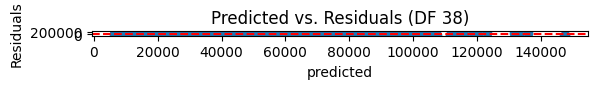

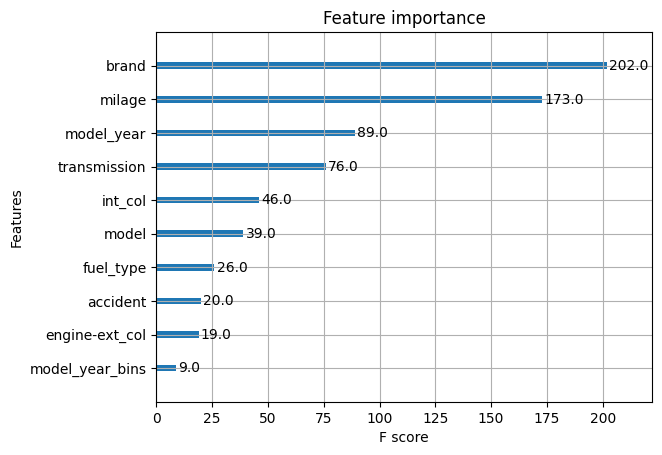

RMSE for DF 39: 23252.240358134994


c:\Users\avira\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


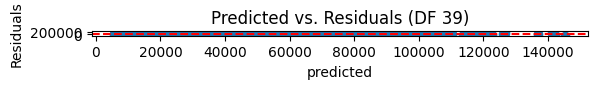

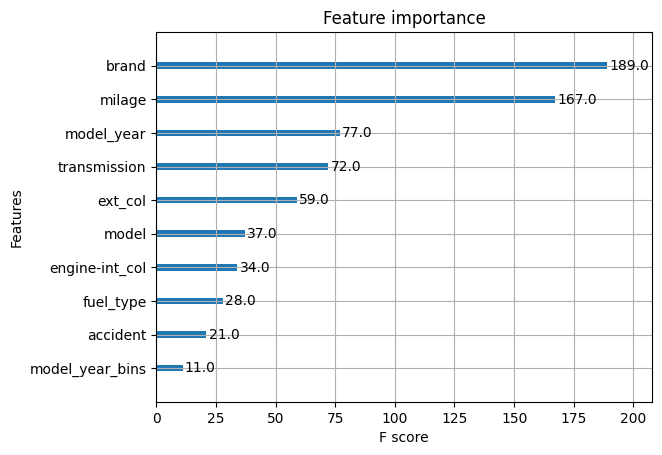

RMSE for DF 40: 23267.155636094292


c:\Users\avira\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


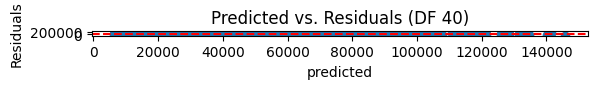

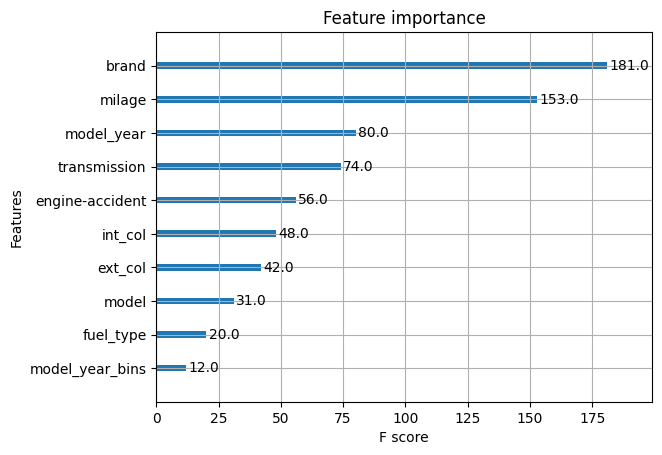

RMSE for DF 41: 23543.72757722695


c:\Users\avira\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


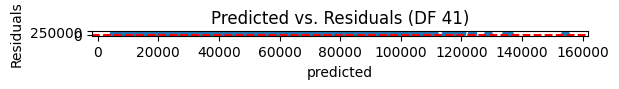

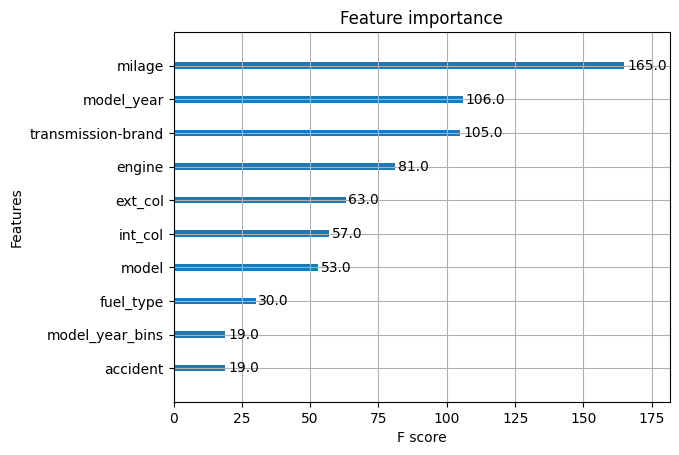

RMSE for DF 42: 23285.80456037602


c:\Users\avira\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


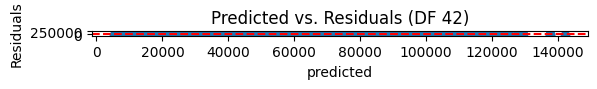

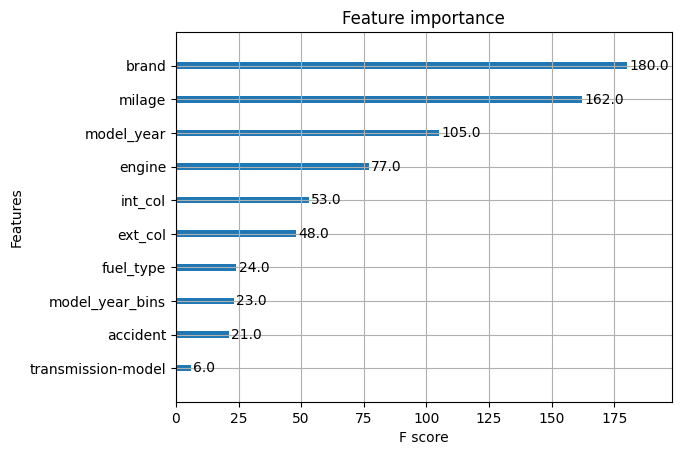

RMSE for DF 43: 24138.859567128322


c:\Users\avira\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


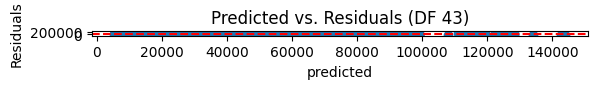

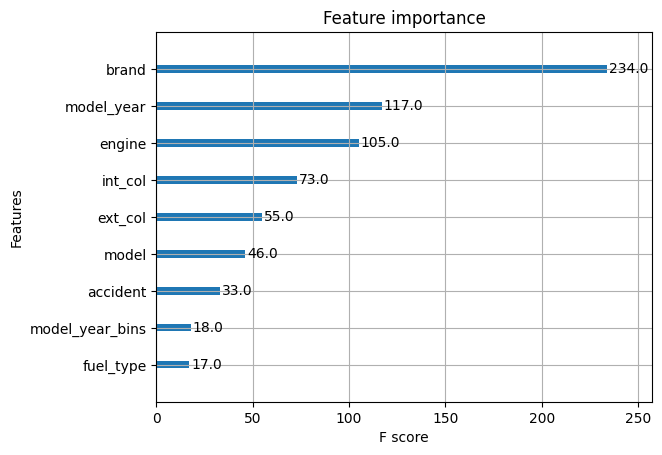

RMSE for DF 44: 23165.44937435187


c:\Users\avira\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


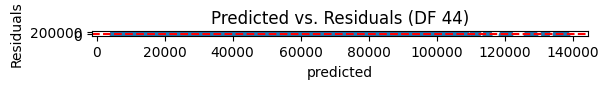

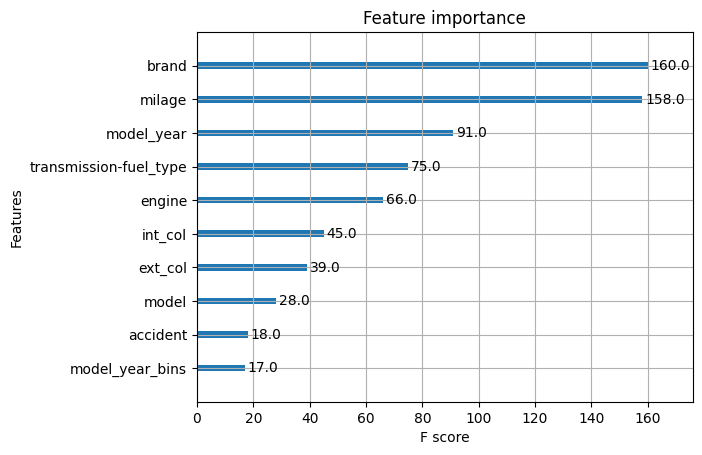

c:\Users\avira\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


RMSE for DF 45: 23320.291658520622


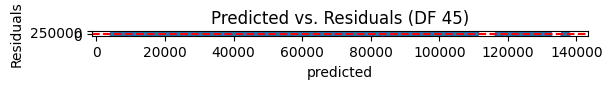

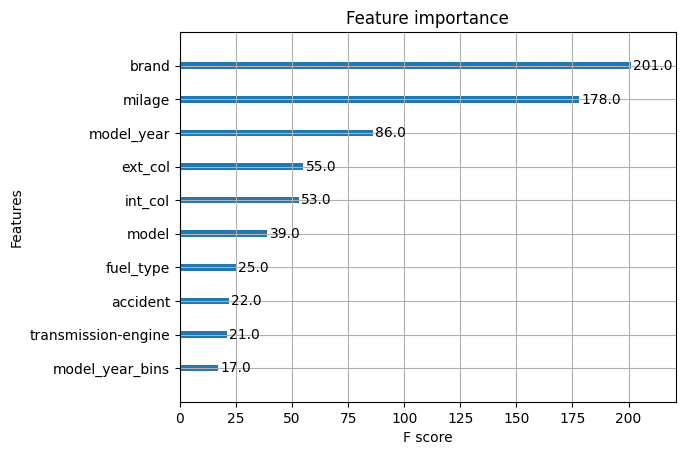

RMSE for DF 46: 23163.38888933931


c:\Users\avira\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


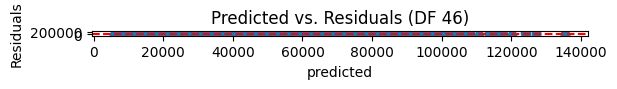

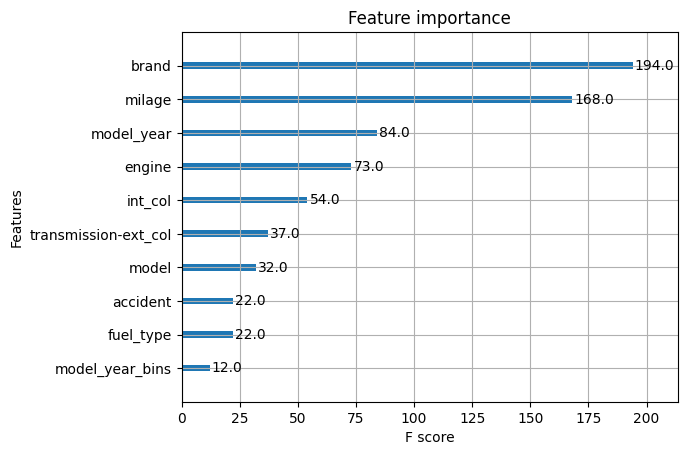

RMSE for DF 47: 23199.656073399798


c:\Users\avira\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


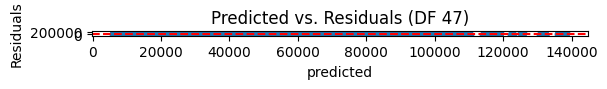

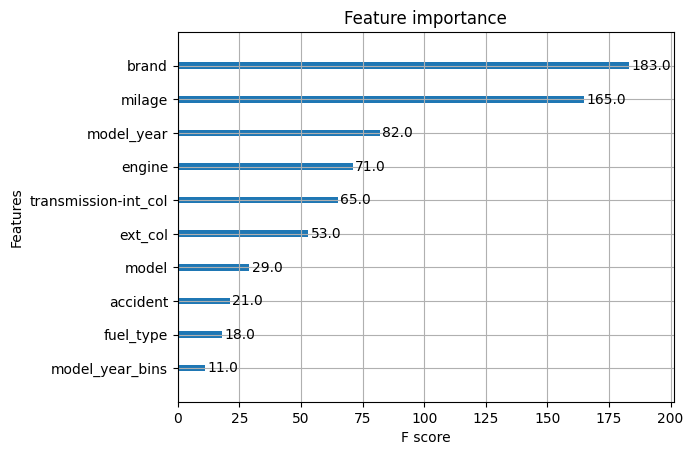

RMSE for DF 48: 23237.87457950472


c:\Users\avira\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


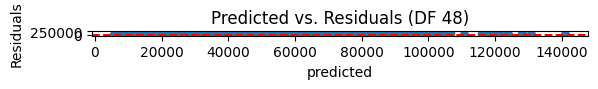

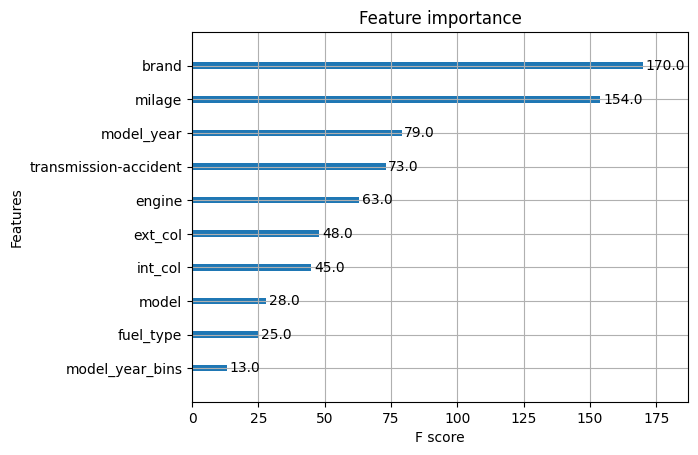

RMSE for DF 49: 23477.395797896836


c:\Users\avira\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


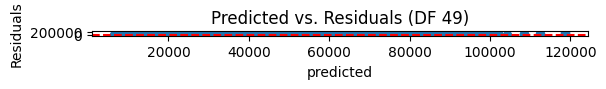

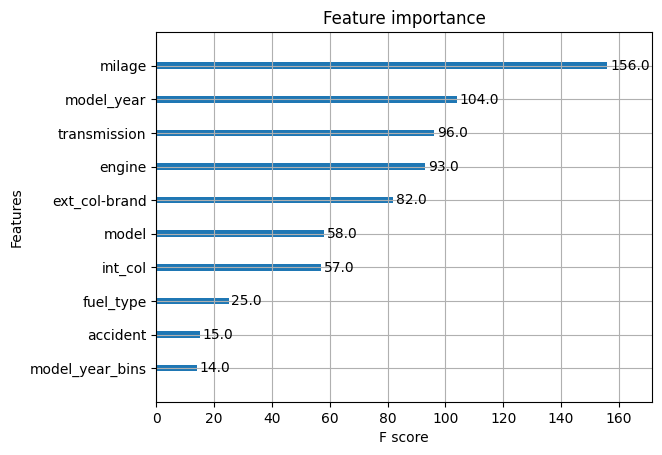

RMSE for DF 50: 23218.28647511767


c:\Users\avira\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


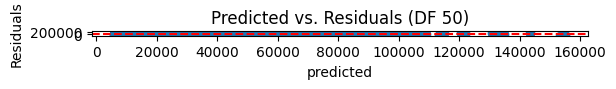

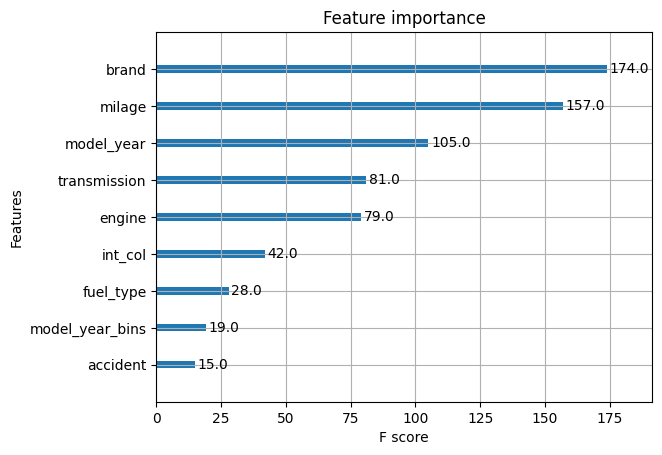

RMSE for DF 51: 24043.895963478466


c:\Users\avira\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


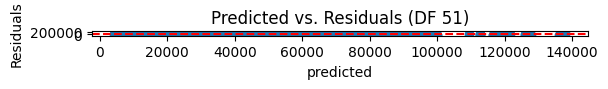

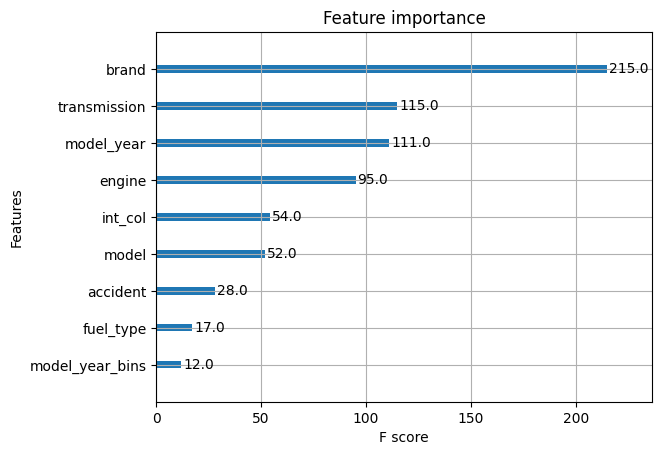

RMSE for DF 52: 23128.722813961


c:\Users\avira\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


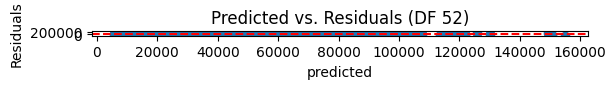

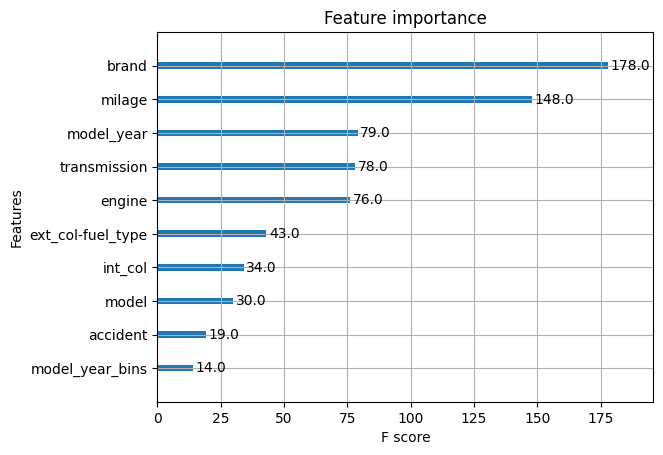

RMSE for DF 53: 23256.00218875502


c:\Users\avira\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


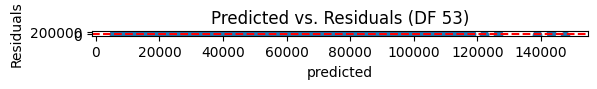

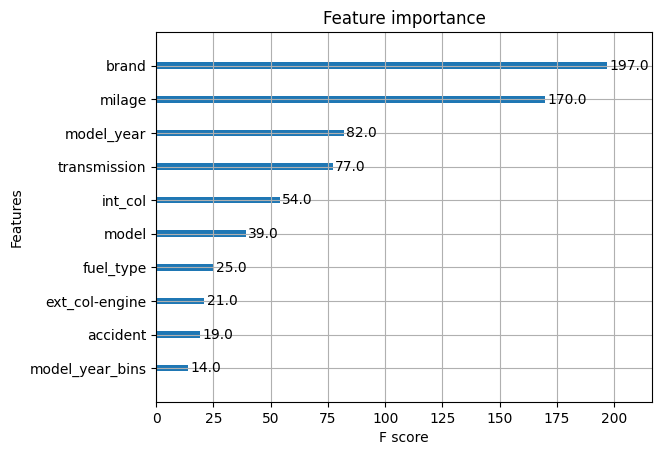

RMSE for DF 54: 23163.38888933931


c:\Users\avira\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


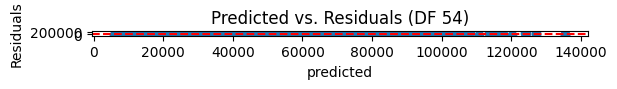

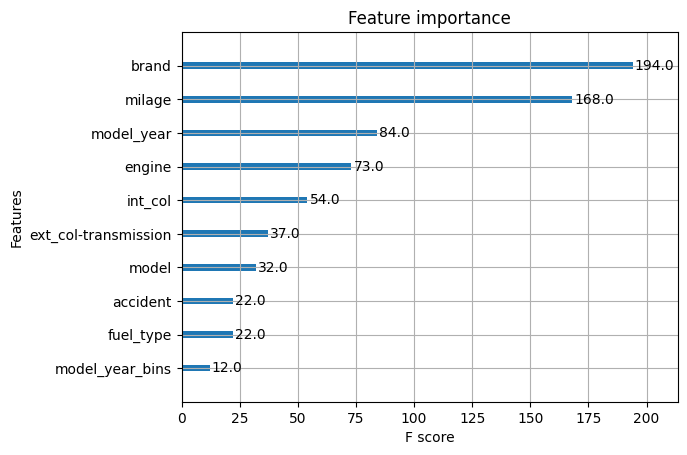

RMSE for DF 55: 23151.893810540576


c:\Users\avira\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


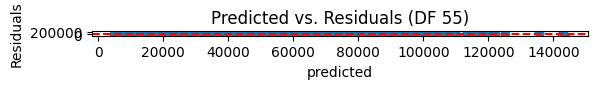

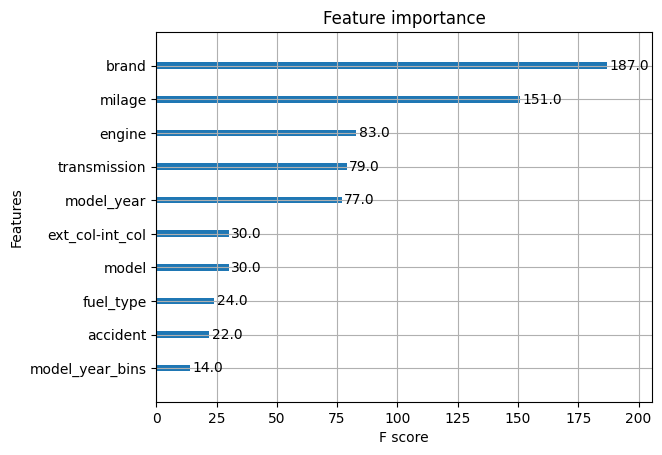

RMSE for DF 56: 23155.212705138274


c:\Users\avira\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


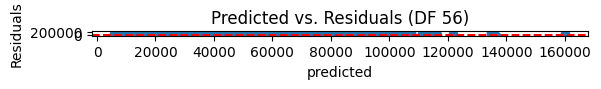

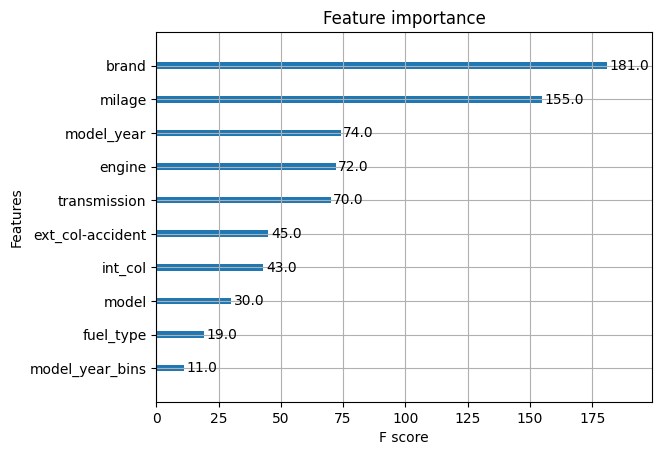

RMSE for DF 57: 23436.25617684771


c:\Users\avira\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


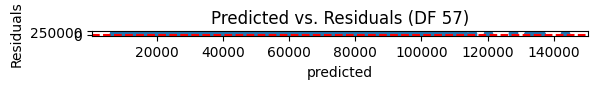

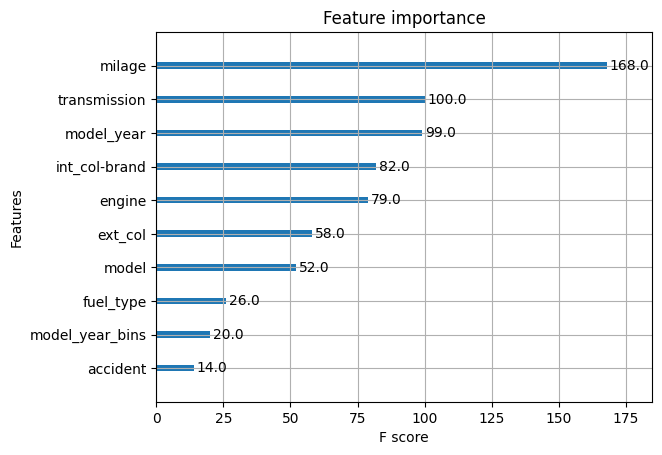

RMSE for DF 58: 23221.846977180296


c:\Users\avira\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


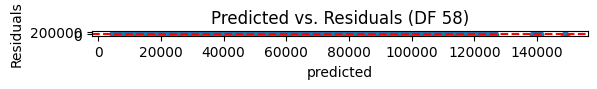

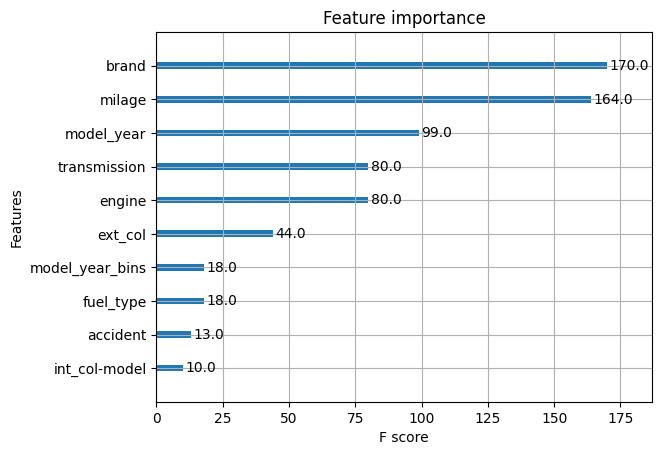

RMSE for DF 59: 24072.100128930375


c:\Users\avira\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


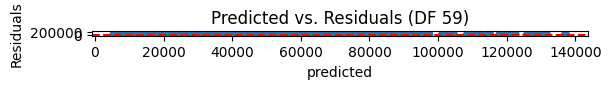

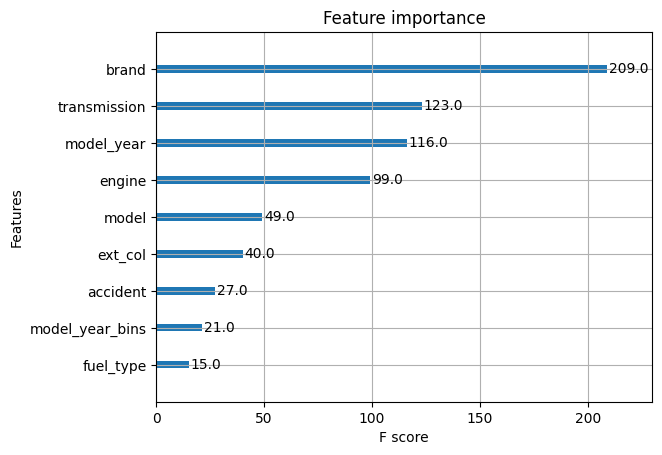

c:\Users\avira\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


RMSE for DF 60: 23148.71945199354


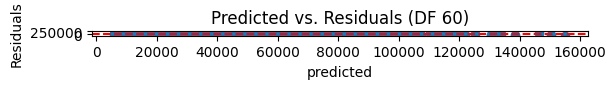

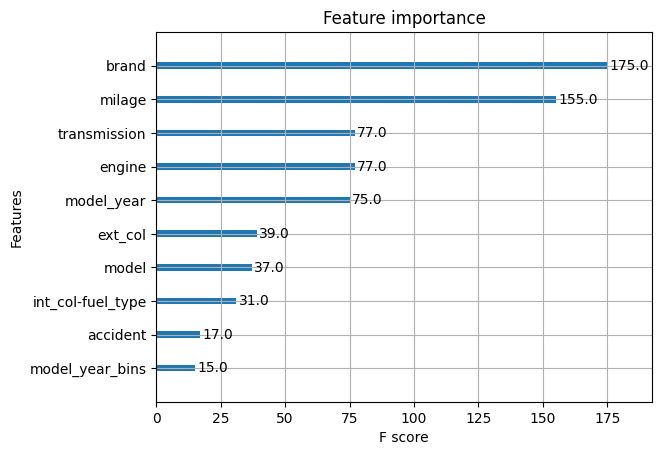

RMSE for DF 61: 23256.35150455583


c:\Users\avira\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


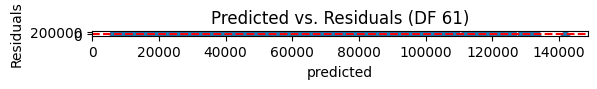

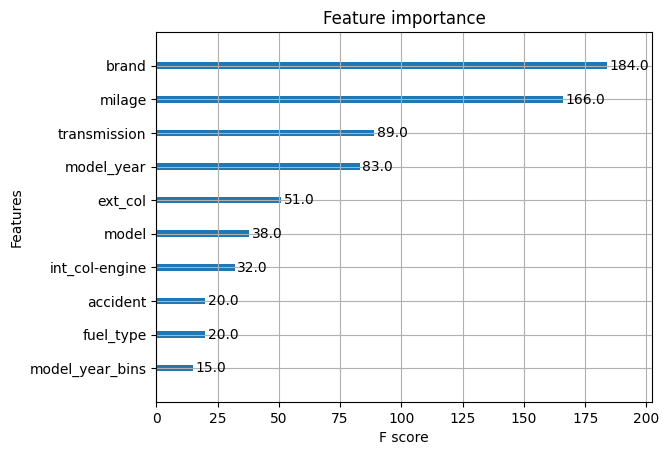

RMSE for DF 62: 23209.75058516906


c:\Users\avira\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


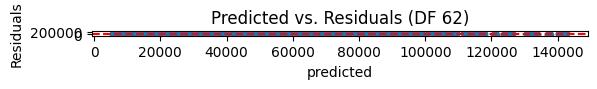

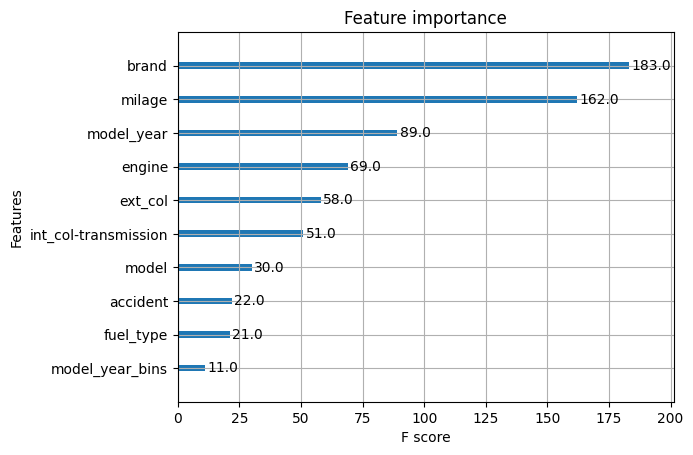

RMSE for DF 63: 23151.893810540576


c:\Users\avira\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


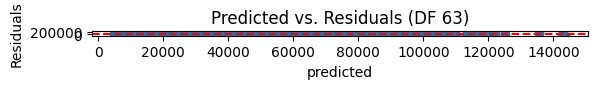

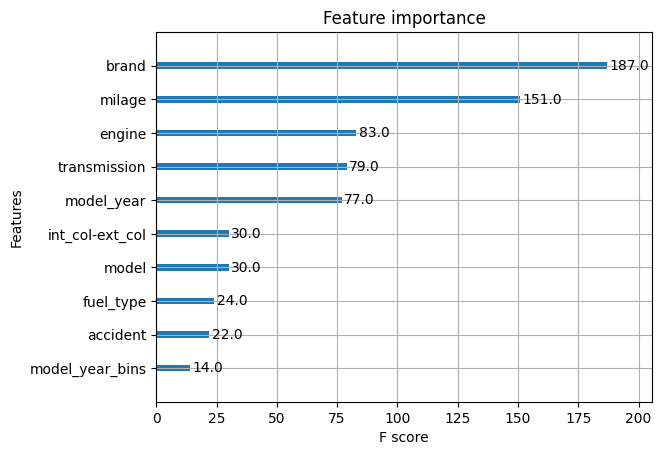

RMSE for DF 64: 23173.290467177016


c:\Users\avira\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


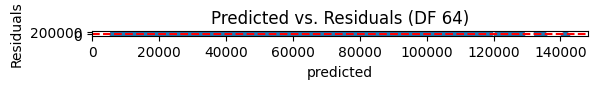

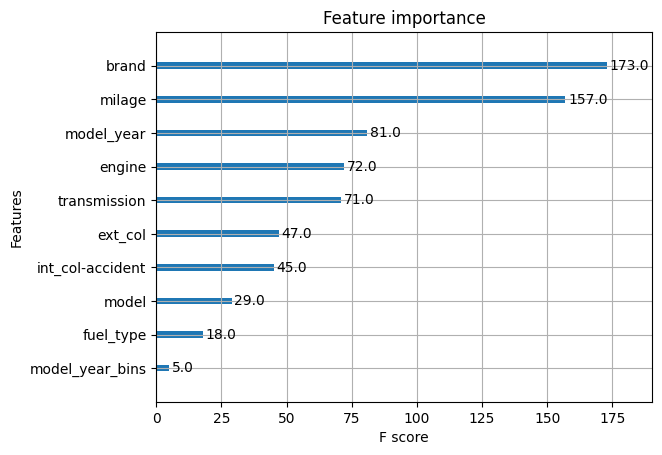

RMSE for DF 65: 23293.359311549284


c:\Users\avira\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


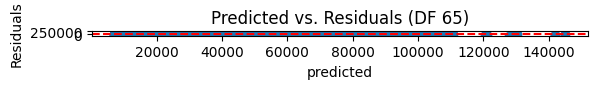

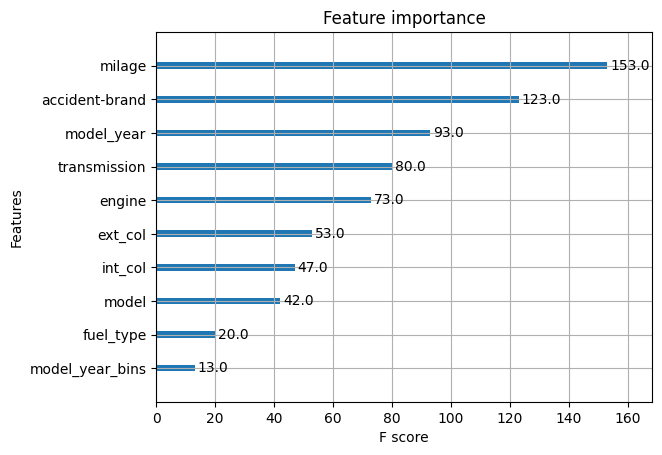

RMSE for DF 66: 23242.6451692167


c:\Users\avira\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


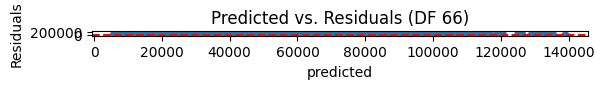

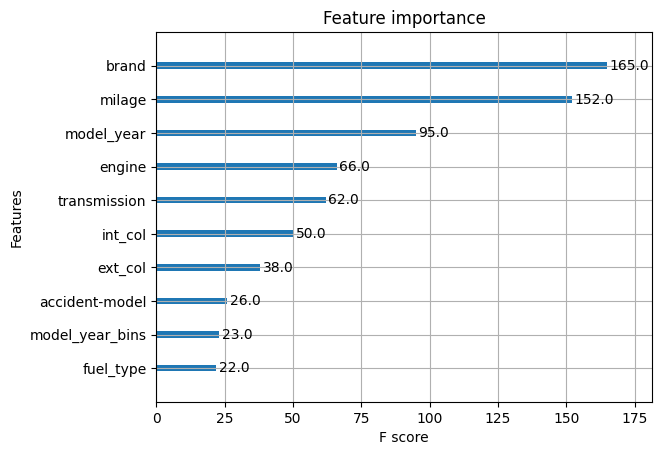

RMSE for DF 67: 24099.851785427283


c:\Users\avira\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


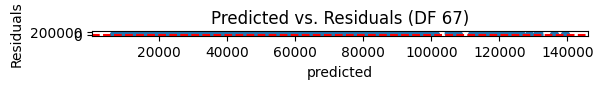

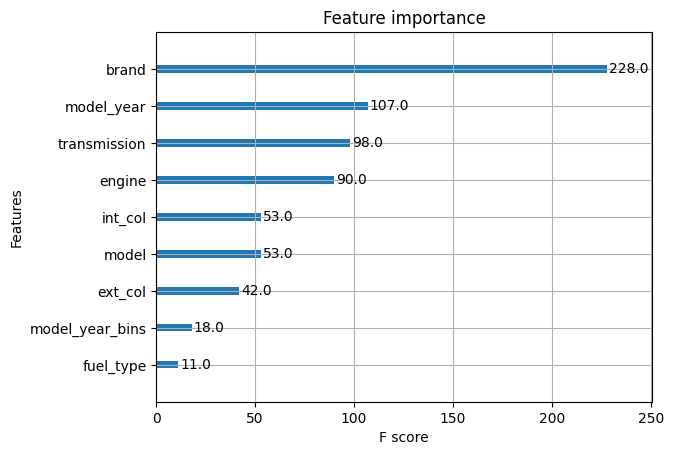

RMSE for DF 68: 23167.825789291826


c:\Users\avira\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


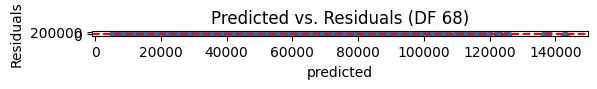

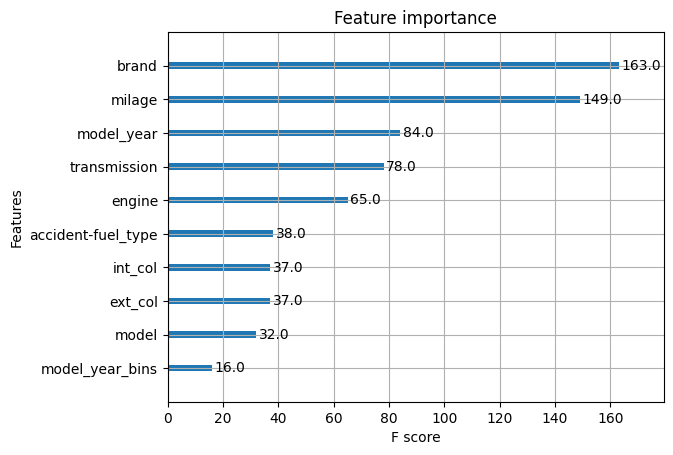

RMSE for DF 69: 23270.64986048993


c:\Users\avira\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


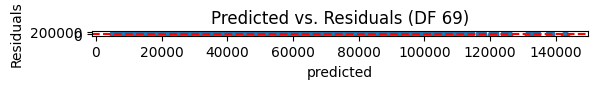

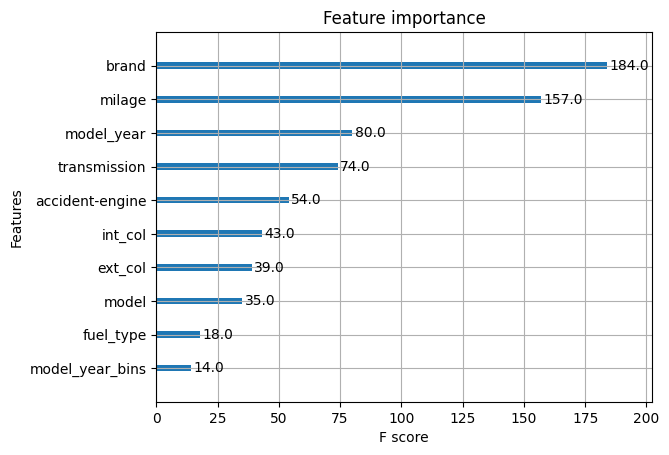

RMSE for DF 70: 23212.021996432784


c:\Users\avira\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


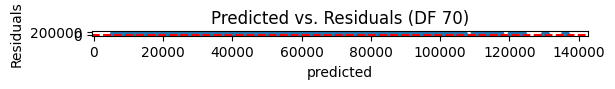

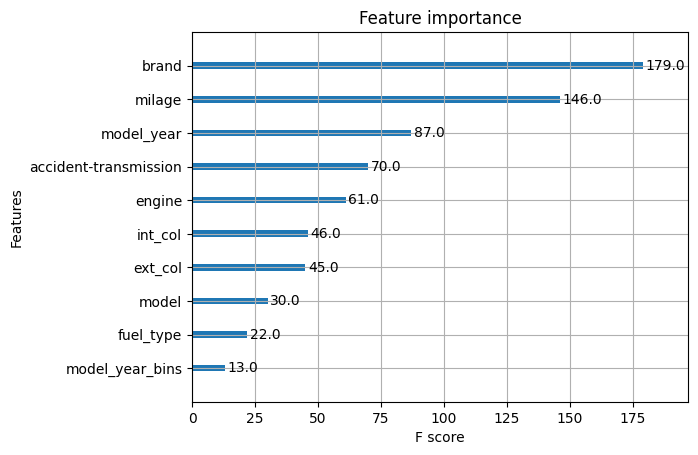

RMSE for DF 71: 23154.923104935748


c:\Users\avira\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


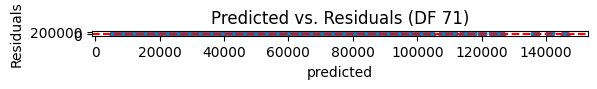

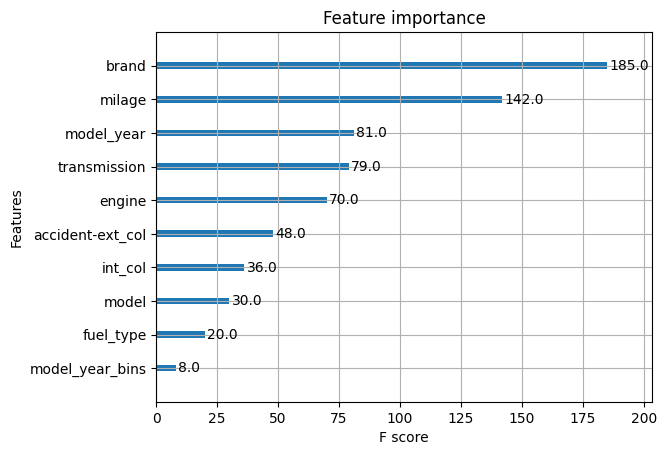

RMSE for DF 72: 23181.39405995333


c:\Users\avira\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


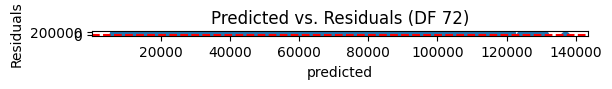

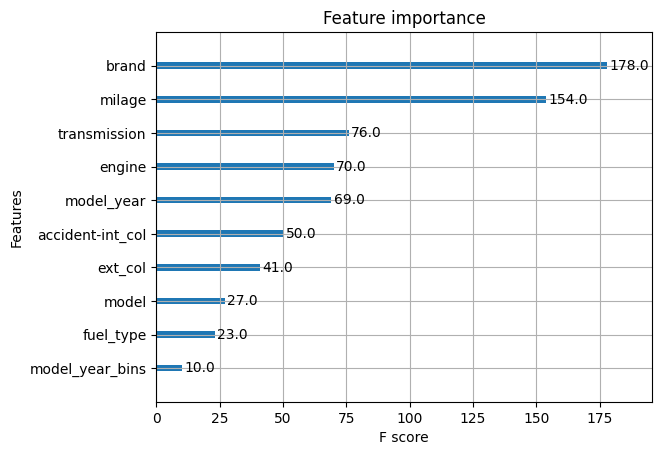

Lowest RMSE: 23128.722813961 (DF 52)


In [314]:
# Define XGBoost model parameters
model_params = {
    'max_depth': 3,
    'learning_rate': 0.1,
    'n_estimators': 100,
    'min_child_weight': 1,
    'gamma': 0,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 0,
    'reg_lambda': 0,
    'nthread': -1,
    'seed': 42
}

# Initialize variables to store lowest RMSE and its corresponding index
lowest_rmse = float('inf')
lowest_rmse_idx = None

# Loop through each DataFrame in combination_test
for idx, df in enumerate(combination_test):
    # Index DataFrame
    X = df.iloc[:, :]
    y = df.iloc[:, -2]
    
    # Drop unnecessary columns
    X.drop(['price', 'id'], axis=1, inplace=True)
    
    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # Initialize XGBoost regressor with defined parameters
    model = xgb.XGBRegressor(**model_params)
    
    # Fit model to training data
    model.fit(X_train, y_train)
    
    # Make predictions on test data
    predictions = model.predict(X_test)
    
    # Calculate Root Mean Squared Error (RMSE)
    rmse = mean_squared_error(y_test, predictions, squared=False)
    
    # Print RMSE for current DataFrame
    print(f"RMSE for DF {idx+1}: {rmse}")
    
    # Check if current RMSE is lowest
    if rmse < lowest_rmse:
        lowest_rmse = rmse
        lowest_rmse_idx = idx + 1

    # Calculate residuals
    residuals = y_test - predictions
    
    # Plot predicted vs. residuals
    plt.subplot(len(combination_test), 1, idx+1)
    plt.scatter(predictions, residuals)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.title(f'Predicted vs. Residuals (DF {idx+1})')
    plt.xlabel('predicted')
    plt.ylabel('Residuals')
    
    # Plot feature importance
    xgb.plot_importance(model)
    plt.show()

# Print lowest RMSE and its corresponding DataFrame number
print(f"Lowest RMSE: {lowest_rmse} (DF {lowest_rmse_idx})")


In [315]:
X = df.iloc[:,:]
y = df.iloc[:,-2]

In [316]:
X.drop('price',axis=1,inplace=True)
X.drop('id',axis=1,inplace=True)


In [317]:
model = xgb.XGBRegressor(
    max_depth=3,
    learning_rate=0.1,
    n_estimators=100,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0,
    reg_lambda=0,
    nthread=-1,
    seed=42
)

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42)
model.fit(X_train, y_train)



XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None, nthread=-1,
             num_parallel_tree=None, ...)

In [318]:
predictions = model.predict(X_test)
cv_scores = cross_val_score(model, X, y, cv=5)
print("Cross-Validation Scores:", cv_scores)
test_score = model.score(X_test, y_test)
print("R2 Score:", test_score)

Cross-Validation Scores: [0.4309001  0.43548387 0.41965234 0.45079017 0.43472207]
R2 Score: 0.4328118562698364


Root Mean Squared Error: 23181.39405995333


c:\Users\avira\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Text(0, 0.5, 'Residuals')

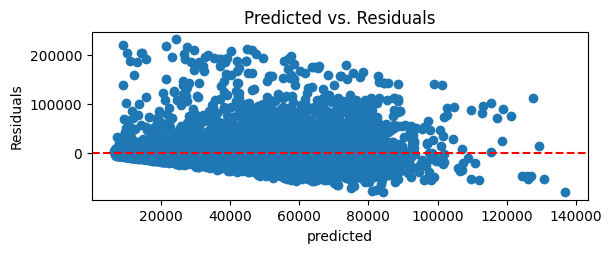

In [319]:
rmse = mean_squared_error(y_test, predictions, squared=False)
print("Root Mean Squared Error:", rmse)

residuals = y_test - predictions
plt.subplot(2, 1, 1)
plt.scatter(predictions, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Predicted vs. Residuals')
plt.xlabel('predicted')
plt.ylabel('Residuals')


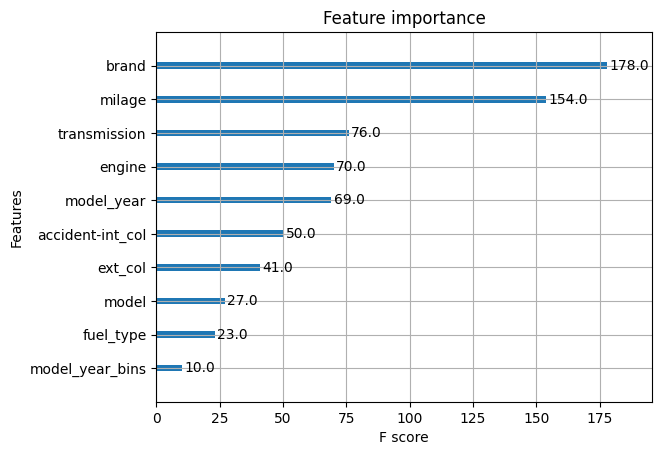

In [320]:
xgb.plot_importance(model)
plt.show()

In [321]:
comparision = pd.DataFrame({'actual':y_test,'predicted':predictions})
comparision.to_csv('comparisions.csv')

In [322]:
df = pd.read_csv('kagglex-cohort4/test.csv')
percentage_error = np.abs((y_test - predictions) / y_test) * 100
error_df = pd.DataFrame({'actual':y_test,'predicted':predictions,'error':percentage_error})
error_df = error_df[error_df['error'] > 20]
error_df.to_csv('bad_predictions.csv')
matched_ids = error_df.index
matched_instances_df = df[df.index.isin(matched_ids)]

In [323]:
for column in matched_instances_df.iloc[:, 1:-1].columns:
    print(f'Column name: {column}\nColumn unique values count:\n{matched_instances_df[column].value_counts()}\n')

Column name: brand
Column unique values count:
brand
BMW              962
Ford             838
Chevrolet        578
Mercedes-Benz    576
Audi             338
Porsche          335
Toyota           296
Lexus            293
Jeep             267
Land             240
Cadillac         199
Nissan           163
Dodge            138
GMC              131
RAM              117
INFINITI         114
Lincoln          107
Jaguar            99
Subaru            92
Honda             84
Hyundai           78
Mazda             78
Volkswagen        74
Kia               67
Acura             60
Volvo             52
MINI              49
Buick             41
Genesis           35
Maserati          34
Bentley           34
Chrysler          32
Hummer            23
Lamborghini       21
Mitsubishi        19
Pontiac           17
Tesla             17
Rolls-Royce       16
Alfa              14
Scion              6
Aston              6
Ferrari            6
Saturn             5
Rivian             4
Lotus              3
Mc

In [324]:
matched_instances_df

id          brand                                       model  \
1      54274          Lexus                                 RX 350 Base   
4      54277            BMW                                X6 xDrive40i   
6      54279           Land  Rover Range Rover 3.0L V6 Supercharged HSE   
7      54280           Land   Rover Range Rover Velar P250 SE R-Dynamic   
11     54284            Kia                            Optima Hybrid LX   
...      ...            ...                                         ...   
36149  90422         Toyota                           Supra A91 Edition   
36154  90427           Land    Rover Range Rover Velar P250 S R-Dynamic   
36167  90440       Cadillac                       Escalade ESV Platinum   
36171  90444            RAM                               2500 Big Horn   
36174  90447  Mercedes-Benz                        AMG C 43 Base 4MATIC   

       model_year  milage fuel_type  \
1            2015  128032  Gasoline   
4            2020   90000  Gasoline   
6            2019   41200  Gasoline   
7            2019   58000  Gasoline   
11           2013  103111    Hybrid   
...           ...     ...       ...   
36149        2021    6400  Gasoline   
36154        2020   58000  Gasoline   
36167        2017  134000  Gasoline   
36171        2021   18000  Gasoline   
36174        2017   57000  Gasoline   

                                                  engine  \
1          275.0HP 3.5L V6 Cylinder Engine Gasoline Fuel   
4      335.0HP 3.0L Straight 6 Cylinder Engine Gasoli...   
6          380.0HP 3.0L V6 Cylinder Engine Gasoline Fuel   
7           247.0HP 2.0L 4 Cylinder Engine Gasoline Fuel   
11     199.0HP 2.4L 4 Cylinder Engine Gas/Electric Hy...   
...                                                  ...   
36149  382.0HP 3.0L Straight 6 Cylinder Engine Gasoli...   
36154       247.0HP 2.0L 4 Cylinder Engine Gasoline Fuel   
36167       420.0HP 6.2L 8 Cylinder Engine Gasoline Fuel   
36171       410.0HP 6.4L 8 Cylinder Engine Gasoline Fuel   
36174      385.0HP 3.0L V6 Cylinder Engine Gasoline Fuel   

                         transmission ext_col int_col  \
1                         8-Speed A/T  Silver   Black   
4                         8-Speed A/T   White   Black   
6                                 A/T  Silver   Black   
7                                 A/T   White   Black   
11                                A/T  Silver   Beige   
...                               ...     ...     ...   
36149                             A/T    Gray   Black   
36154                             A/T     Red   White   
36167                     8-Speed A/T   Black   Black   
36171                     6-Speed A/T    Gray    Gray   
36174  Transmission w/Dual Shift Mode    Gray   Black   

                                     accident clean_title  
1                               None reported         Yes  
4      At least 1 accident or damage reported         Yes  
6      At least 1 accident or damage reported         Yes  
7      At least 1 accident or damage reported         Yes  
11                              None reported         Yes  
...                                       ...         ...  
36149                           None reported         Yes  
36154                           None reported         Yes  
36167                           None reported         Yes  
36171                           None reported         Yes  
36174  At least 1 accident or damage reported         Yes  

[6764 rows x 12 columns]

# prediction

In [325]:
dft=pd.read_csv('kagglex-cohort4/test.csv')
dft_copy=pd.read_csv('kagglex-cohort4/test.csv')
threshold = 3

encoded_columns = ['int_col', 'ext_col']
ordinal_encoder = OrdinalEncoder()
dft[encoded_columns] = ordinal_encoder.fit_transform(dft[encoded_columns])
bin_edges = range(1970, 2031, 5)
bin_labels = [f'{start}-{start+9}' for start in bin_edges[:-1]]
dft['model_year_bins'] = pd.cut(df['model_year'], bins=bin_edges, labels=bin_labels, right=False)
dft.drop('model_year',axis=1,inplace=True)
dft.drop('clean_title',axis=1,inplace=True)
dft.drop('id',axis=1,inplace=True)
categorical_columns = dft.select_dtypes(include=['object', 'category']).columns
threshold_frequency = 250
for col in categorical_columns:
    value_counts_col = dft[col].value_counts()
    
    less_than_threshold = value_counts_col[value_counts_col < threshold_frequency]
    
    dft[col] = dft[col].apply(lambda x: 'Other' if x in less_than_threshold else x)
categorical_columns = dft.select_dtypes(include=['object', 'category']).columns

for col in categorical_columns:
    category_frequency = dft[col].value_counts(normalize=True)
    dft[col] = dft[col].map(category_frequency)

In [326]:
predictions=predictions = model.predict(dft)

ValueError: feature_names mismatch: ['brand', 'model', 'model_year', 'milage', 'fuel_type', 'engine', 'transmission', 'ext_col', 'accident-int_col', 'clean_title', 'model_year_bins'] ['brand', 'model', 'milage', 'fuel_type', 'engine', 'transmission', 'ext_col', 'int_col', 'accident', 'model_year_bins']
expected model_year, clean_title, accident-int_col in input data
training data did not have the following fields: accident, int_col

In [ ]:
dft

brand     model  milage  fuel_type    engine  transmission  ext_col  \
0      0.090236  0.007048   73000   0.912943  0.010640      0.311555    220.0   
1      0.042285  0.923555  128032   0.912943  0.739021      0.133156    187.0   
2      0.090236  0.923555   51983   0.912943  0.739021      0.061244     26.0   
3      0.037587  0.923555   29500   0.912943  0.739021      0.117901    220.0   
4      0.134151  0.923555   90000   0.912943  0.010779      0.133156    220.0   
...         ...       ...     ...        ...       ...           ...      ...   
36178  0.020700  0.923555    4500   0.912943  0.016803      0.039881     88.0   
36179  0.082718  0.923555  185000   0.912943  0.739021      0.015228    163.0   
36180  0.043501  0.923555  116000   0.912943  0.739021      0.013017     12.0   
36181  0.013708  0.923555   39000   0.912943  0.739021      0.039881     17.0   
36182  0.082718  0.923555  162731   0.028135  0.739021      0.311555     17.0   

       int_col  accident  model_year_bins  
0          8.0  0.735097         0.213388  
1         10.0  0.735097         0.387834  
2        107.0  0.735097         0.387834  
3        107.0  0.264903         0.387834  
4         10.0  0.264903         0.233756  
...        ...       ...              ...  
36178     10.0  0.735097         0.387834  
36179     53.0  0.264903         0.043363  
36180     53.0  0.735097         0.213388  
36181     82.0  0.735097         0.387834  
36182     10.0  0.264903         0.213388  

[36183 rows x 10 columns]

In [ ]:
submission_df = pd.DataFrame({'id': dft_copy['id'], 'price': predictions})
submission_df.to_csv('submission.csv', index=False)
